# County level analysis

In [1]:
import numpy as np
import pandas as pd
import geopandas as gp

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm
from matplotlib.gridspec import GridSpec

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Avenir'
plt.rcParams['mathtext.rm'] = 'Avenir'
plt.rcParams['mathtext.it'] = 'Avenir:italic'
plt.rcParams['mathtext.bf'] = 'Avenir:bold'
plt.rcParams['font.size'] = 20
plt.rcParams['pdf.fonttype'] = 42

cm_data = np.loadtxt("../../other/plotting_tools/turku.txt")[::-1]
turku_map = LinearSegmentedColormap.from_list('turku', cm_data)

cm_data = np.loadtxt("../../other/plotting_tools/vik.txt")
vik_map = LinearSegmentedColormap.from_list('vik', cm_data)

In [2]:
# Import plotting shapefiles
county_shp = gp.read_file('../../other/plotting_tools/counties_contig_plot.shp')
county_shp["fips"] = county_shp["fips"].astype(str).str.zfill(5)

# Add State filter for plot
county_shp_plot = county_shp.copy()
county_shp_plot['state'] = county_shp_plot['fips'].str[:2]
county_shp_plot.set_index(['state'], inplace=True)
StateDrop = ['53', '41', '16', '06', '04', '49', '56', '30', '08', '35', '32'] # Western half of CONUS
county_shp_plot = county_shp_plot.drop(StateDrop)
county_shp_plot.set_index(['fips'], inplace=True)

states = gp.read_file('../../other/plotting_tools/states_contig_plot.shp')
coast = gp.read_file('../../other/plotting_tools/coast_contig_plot.shp')

In [3]:
def get_weather(x):
    return x['gdd']*beta_gdd + x['edd']*beta_edd + x['prcp']*beta_prcp + x['prcp2']*beta_prcp2

In [4]:
coef = pd.read_csv('../../data/yield/baseline_coeffs+95.csv', index_col=0)
beta_gdd = coef.loc['gdd']['coeff']
beta_edd = coef.loc['edd']['coeff']
beta_prcp = coef.loc['prcp']['coeff']
beta_prcp2 = coef.loc['prcp2']['coeff']

In [5]:
def get_norm(lst):

    minima = min(lst)
    maxima = max(lst)

    return mpl.colors.Normalize(vmin=minima, vmax=maxima, clip=True)

def get_custom_cmap(lst):

    minima = min(lst)
    maxima = max(lst)

    norm = get_norm(lst)
    mapper = cm.ScalarMappable(norm=norm, cmap=turku_map) ########### chanhe
    
    return [mapper.to_rgba(v) for v in lst]

In [6]:
# Read in GMFD data
gmfd_yield = pd.read_csv('../../data/yield/all_gmfd_historical.csv')
gmfd_yield["fips"] = gmfd_yield["fips"].astype(str).str.zfill(5)
yield_fips = gmfd_yield['fips'].unique() # Only take fips codes
#### Note that the simulated values from R only include the USDA county-years, 
#### so there would be some values missing for comparison to the models.

gmfd = pd.read_csv('../../data/climate/GMFD/agvar_historical_gmfd.csv')
gmfd = gmfd.query('year >= 1956 and year <= 2005')
gmfd['prcp2'] = gmfd['prcp']**2
gmfd['weather'] = gmfd.apply(get_weather, axis=1)
gmfd["fips"] = gmfd["fips"].astype(str).str.zfill(5)
all_fips = gmfd['fips'].unique()
gmfd.set_index(['fips', 'year'], inplace = True)

In [7]:
# Construct national weights (total production by weighted sum of counties)
weights = pd.read_csv('../../data/usda/maize_county_yield_area.csv').filter(["fips", "year", "area","yield"])
weights = weights.query('year >= 1956 and year <= 2005')
weights['fips'] = weights['fips'].astype(str).str.zfill(5)
weights.sort_values(by = ['fips', 'year'], inplace = True)
weights.set_index(['fips', 'year'], inplace = True)
weights["national_weight"] = weights["area"] * weights["yield"]
weights_norm = weights.groupby("year").sum().drop(columns = ["yield", "area"])
# Normalise
weights = pd.merge(weights.reset_index().filter(["fips","year","national_weight"]), weights_norm, on = "year")
weights["national_weight"] = weights["national_weight_x"] / weights["national_weight_y"]
weights.drop(columns = ["national_weight_x", "national_weight_y"],inplace=True)
weights = weights.set_index(['fips','year']).sort_index()
weights = weights.filter(['national_weight'])

In [8]:
# Average historical weights
weights_all = weights.groupby('fips').sum()
weights_all = weights_all.loc[yield_fips]
weights_all['national_weight'] = weights_all['national_weight']/weights_all['national_weight'].sum()

In [9]:
# Highest producing county (McLean, IL)
weights_all.sort_values(by='national_weight', ascending=False).iloc[0]

national_weight    0.006775
Name: 17113, dtype: float64

In [10]:
# Number of counties
len(weights_all)

2119

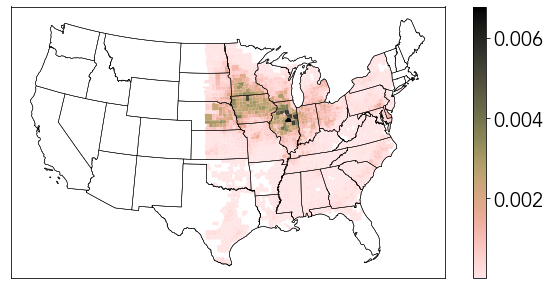

In [11]:
# Check weights
fig, ax = plt.subplots(figsize=(10,5))

plotdat = pd.merge(county_shp_plot, weights_all, on='fips', how='inner')
plotdat.plot(column='national_weight', ax=ax, legend=True, cmap=turku_map)

states.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
coast.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
ax.tick_params(labelbottom=False, labelleft=False, color = 'white')
plt.show()

In [36]:
# Read in NEX models
nex_models = !ls ../../data/climate/NEX-GDDP/hist
nex = {model.replace("agvar_historical_r1i1p1_","").replace(".csv","") : pd.read_csv("../../data/climate/NEX-GDDP/hist/" + model) for model in nex_models}
nex_models = [model.replace("agvar_historical_r1i1p1_","").replace(".csv","") for model in nex_models]

# NEX EDD
nex_edd = pd.DataFrame.from_dict({model : nex[model].set_index(['fips','year'])['edd'] for model in nex_models}).dropna()
nex_edd = nex_edd.reset_index()
nex_edd["fips"] = nex_edd["fips"].astype(str).str.zfill(5)
nex_edd.set_index(['fips','year'], inplace=True)

# NEX GDD
nex_gdd = pd.DataFrame.from_dict({model : nex[model].set_index(['fips','year'])['gdd'] for model in nex_models}).dropna()
nex_gdd = nex_gdd.reset_index()
nex_gdd["fips"] = nex_gdd["fips"].astype(str).str.zfill(5)
nex_gdd.set_index(['fips','year'], inplace=True)

# NEX GDD
nex_prcp = pd.DataFrame.from_dict({model : nex[model].set_index(['fips','year'])['prcp'] for model in nex_models}).dropna()
nex_prcp = nex_prcp.reset_index()
nex_prcp["fips"] = nex_prcp["fips"].astype(str).str.zfill(5)
nex_prcp.set_index(['fips','year'], inplace=True)

# NEX weather
for model in nex_models:
    tmp = nex[model]
    tmp['prcp2'] = tmp['prcp']**2
    tmp['weather'] = tmp.apply(get_weather, axis=1)
    nex[model] = tmp

nex_weather = pd.DataFrame.from_dict({model : nex[model].set_index(['fips','year'])['weather'] for model in nex_models}).dropna()
nex_weather = nex_weather.reset_index()
nex_weather["fips"] = nex_weather["fips"].astype(str).str.zfill(5)
nex_weather.set_index(['fips','year'], inplace=True)   

In [37]:
# Read in CMIP models
cmip_models = !ls ../../data/climate/CMIP
cmip = {model.replace("agvar_","").replace("historical+rcp85","").replace(".csv","").replace(".csv","")[:-1] : pd.read_csv("../../data/climate/CMIP/" + model) for model in cmip_models}
cmip_models = [model.replace("agvar_","").replace("historical+rcp85","").replace(".csv","")[:-1] for model in cmip_models]

# CMIP EDD
cmip_edd = pd.DataFrame.from_dict({model : cmip[model].set_index(['fips','year'])['edd'] for model in cmip_models}).dropna()
cmip_edd = cmip_edd.reset_index()
cmip_edd["fips"] = cmip_edd["fips"].astype(str).str.zfill(5)
cmip_edd.set_index(['fips','year'], inplace=True)

# CMIP GDD
cmip_gdd = pd.DataFrame.from_dict({model : cmip[model].set_index(['fips','year'])['gdd'] for model in cmip_models}).dropna()
cmip_gdd = cmip_gdd.reset_index()
cmip_gdd["fips"] = cmip_gdd["fips"].astype(str).str.zfill(5)
cmip_gdd.set_index(['fips','year'], inplace=True)

# CMIP GDD
cmip_prcp = pd.DataFrame.from_dict({model : cmip[model].set_index(['fips','year'])['prcp'] for model in cmip_models}).dropna()
cmip_prcp = cmip_prcp.reset_index()
cmip_prcp["fips"] = cmip_prcp["fips"].astype(str).str.zfill(5)
cmip_prcp.set_index(['fips','year'], inplace=True)

# CMIP weather
for model in cmip_models:
    tmp = cmip[model]
    tmp['prcp2'] = tmp['prcp']**2
    tmp['weather'] = tmp.apply(get_weather, axis=1)
    cmip[model] = tmp

cmip_weather = pd.DataFrame.from_dict({model : cmip[model].set_index(['fips','year'])['weather'] for model in cmip_models}).dropna()
cmip_weather = cmip_weather.reset_index()
cmip_weather["fips"] = cmip_weather["fips"].astype(str).str.zfill(5)
cmip_weather.set_index(['fips','year'], inplace=True)   

## Preliminary figures: national (unweighted) average and median-performing models

In [38]:
# Get national averages (unweighted)

# NEX
nex_weather_av = nex_weather.loc[yield_fips].groupby('year').mean()
nex_gdd_av = nex_gdd.groupby('year').mean()
nex_edd_av = nex_edd.groupby('year').mean()
nex_prcp_av = nex_prcp.groupby('year').mean()

# CMIP
cmip_weather_av = cmip_weather.loc[yield_fips].groupby('year').mean()
cmip_gdd_av = cmip_gdd.groupby('year').mean()
cmip_edd_av = cmip_edd.groupby('year').mean()
cmip_prcp_av = cmip_prcp.groupby('year').mean()

# GMFD
gmfd_av = gmfd.drop(columns=['state','prcp2']).loc[yield_fips].groupby('year').mean()

In [39]:
########## Weather
# NEX
weather_nex_mean_error = [(nex_weather_av[model].mean() - gmfd_av['weather'].mean()) / gmfd_av['weather'].mean() * 100 for model in nex_models]
weather_nex_sd_error = [(nex_weather_av[model].std() - gmfd_av['weather'].std()) / gmfd_av['weather'].std() * 100 for model in nex_models]
weather_nex_q10_error = [(nex_weather_av[model].quantile(q=0.1) - gmfd_av['weather'].quantile(q=0.1)) / gmfd_av['weather'].quantile(q=0.1) * 100 for model in nex_models]
weather_nex_min_error = [(nex_weather_av[model].min() - gmfd_av['weather'].min()) / gmfd_av['weather'].min() * 100 for model in nex_models]

# CMIP
weather_cmip_mean_error = [(cmip_weather_av[model].mean() - gmfd_av['weather'].mean()) / gmfd_av['weather'].mean() * 100 for model in cmip_models]
weather_cmip_sd_error = [(cmip_weather_av[model].std() - gmfd_av['weather'].std()) / gmfd_av['weather'].std() * 100 for model in cmip_models]
weather_cmip_q10_error = [(cmip_weather_av[model].quantile(q=0.1) - gmfd_av['weather'].quantile(q=0.1)) / gmfd_av['weather'].quantile(q=0.1) * 100 for model in cmip_models]
weather_cmip_min_error = [(cmip_weather_av[model].min() - gmfd_av['weather'].min()) / gmfd_av['weather'].min() * 100 for model in cmip_models]

############## GDD
# NEX
gdd_nex_mean_error = [(nex_gdd_av[model].mean() - gmfd_av['gdd'].mean()) / gmfd_av['gdd'].mean() * 100 for model in nex_models]
gdd_nex_sd_error = [(nex_gdd_av[model].std() - gmfd_av['gdd'].std()) / gmfd_av['gdd'].std() * 100 for model in nex_models]
gdd_nex_q10_error = [(nex_gdd_av[model].quantile(q=0.1) - gmfd_av['gdd'].quantile(q=0.1)) / gmfd_av['gdd'].quantile(q=0.1) * 100 for model in nex_models]
gdd_nex_min_error = [(nex_gdd_av[model].min() - gmfd_av['gdd'].min()) / gmfd_av['gdd'].min() * 100 for model in nex_models]

# CMIP
gdd_cmip_mean_error = [(cmip_gdd_av[model].mean() - gmfd_av['gdd'].mean()) / gmfd_av['gdd'].mean() * 100 for model in cmip_models]
gdd_cmip_sd_error = [(cmip_gdd_av[model].std() - gmfd_av['gdd'].std()) / gmfd_av['gdd'].std() * 100 for model in cmip_models]
gdd_cmip_q10_error = [(cmip_gdd_av[model].quantile(q=0.1) - gmfd_av['gdd'].quantile(q=0.1)) / gmfd_av['gdd'].quantile(q=0.1) * 100 for model in cmip_models]
gdd_cmip_min_error = [(cmip_gdd_av[model].min() - gmfd_av['gdd'].min()) / gmfd_av['gdd'].min() * 100 for model in cmip_models]

############ EDD
# NEX
edd_nex_mean_error = [(nex_edd_av[model].mean() - gmfd_av['edd'].mean()) / gmfd_av['edd'].mean() * 100 for model in nex_models]
edd_nex_sd_error = [(nex_edd_av[model].std() - gmfd_av['edd'].std()) / gmfd_av['edd'].std() * 100 for model in nex_models]
edd_nex_q90_error = [(nex_edd_av[model].quantile(q=0.9) - gmfd_av['edd'].quantile(q=0.9)) / gmfd_av['edd'].quantile(q=0.9) * 100 for model in nex_models]
edd_nex_max_error = [(nex_edd_av[model].max() - gmfd_av['edd'].max()) / gmfd_av['edd'].max() * 100 for model in nex_models]

# CMIP
edd_cmip_mean_error = [(cmip_edd_av[model].mean() - gmfd_av['edd'].mean()) / gmfd_av['edd'].mean() * 100 for model in cmip_models]
edd_cmip_sd_error = [(cmip_edd_av[model].std() - gmfd_av['edd'].std()) / gmfd_av['edd'].std() * 100 for model in cmip_models]
edd_cmip_q90_error = [(cmip_edd_av[model].quantile(q=0.9) - gmfd_av['edd'].quantile(q=0.9)) / gmfd_av['edd'].quantile(q=0.9) * 100 for model in cmip_models]
edd_cmip_max_error = [(cmip_edd_av[model].max() - gmfd_av['edd'].max()) / gmfd_av['edd'].max() * 100 for model in cmip_models]

############ Prcp
# NEX
prcp_nex_mean_error = [(nex_prcp_av[model].mean() - gmfd_av['prcp'].mean()) / gmfd_av['prcp'].mean() * 100 for model in nex_models]
prcp_nex_sd_error = [(nex_prcp_av[model].std() - gmfd_av['prcp'].std()) / gmfd_av['prcp'].std() * 100 for model in nex_models]
prcp_nex_q10_error = [(nex_prcp_av[model].quantile(q=0.1) - gmfd_av['prcp'].quantile(q=0.1)) / gmfd_av['prcp'].quantile(q=0.1) * 100 for model in nex_models]
prcp_nex_min_error = [(nex_prcp_av[model].min() - gmfd_av['prcp'].min()) / gmfd_av['prcp'].min() * 100 for model in nex_models]

# CMIP
prcp_cmip_mean_error = [(cmip_prcp_av[model].mean() - gmfd_av['prcp'].mean()) / gmfd_av['prcp'].mean() * 100 for model in cmip_models]
prcp_cmip_sd_error = [(cmip_prcp_av[model].std() - gmfd_av['prcp'].std()) / gmfd_av['prcp'].std() * 100 for model in cmip_models]
prcp_cmip_q10_error = [(cmip_prcp_av[model].quantile(q=0.1) - gmfd_av['prcp'].quantile(q=0.1)) / gmfd_av['prcp'].quantile(q=0.1) * 100 for model in cmip_models]
prcp_cmip_min_error = [(cmip_prcp_av[model].min() - gmfd_av['prcp'].min()) / gmfd_av['prcp'].min() * 100 for model in cmip_models]

In [40]:
print('Weather:\n')
# Find the median-performing model in each case (NEX)
weather_nex_mean_mpm = nex_models[np.where(weather_nex_mean_error == np.median(weather_nex_mean_error))[0][0]]
print(weather_nex_mean_mpm)
weather_nex_q10_mpm = nex_models[np.where(weather_nex_q10_error == np.median(weather_nex_q10_error))[0][0]]
print(weather_nex_q10_mpm)
weather_nex_sd_mpm = nex_models[np.where(weather_nex_sd_error == np.median(weather_nex_sd_error))[0][0]]
print(weather_nex_sd_mpm)
weather_nex_min_mpm = nex_models[np.where(weather_nex_min_error == np.median(weather_nex_min_error))[0][0]]
print(weather_nex_min_mpm)

print('\n')
# Find the median-performing model in each case (CMIP)
weather_cmip_mean_mpm = cmip_models[np.where(weather_cmip_mean_error == np.median(weather_cmip_mean_error))[0][0]]
print(weather_cmip_mean_mpm)
weather_cmip_q10_mpm = cmip_models[np.where(weather_cmip_q10_error == np.median(weather_cmip_q10_error))[0][0]]
print(weather_cmip_q10_mpm)
weather_cmip_sd_mpm = cmip_models[np.where(weather_cmip_sd_error == np.median(weather_cmip_sd_error))[0][0]]
print(weather_cmip_sd_mpm)
weather_cmip_min_mpm = cmip_models[np.where(weather_cmip_min_error == np.median(weather_cmip_min_error))[0][0]]
print(weather_cmip_min_mpm)

Weather:

CSIRO-Mk3-6-0
CESM1-BGC
MPI-ESM-LR
inmcm4


CESM1-BGC
CCSM4
CCSM4
CCSM4


In [41]:
print('GDD:\n')
# Find the median-performing model in each case (NEX)
gdd_nex_mean_mpm = nex_models[np.where(gdd_nex_mean_error == np.median(gdd_nex_mean_error))[0][0]]
print(gdd_nex_mean_mpm)
gdd_nex_q10_mpm = nex_models[np.where(gdd_nex_q10_error == np.median(gdd_nex_q10_error))[0][0]]
print(gdd_nex_q10_mpm)
gdd_nex_sd_mpm = nex_models[np.where(gdd_nex_sd_error == np.median(gdd_nex_sd_error))[0][0]]
print(gdd_nex_sd_mpm)
gdd_nex_min_mpm = nex_models[np.where(gdd_nex_min_error == np.median(gdd_nex_min_error))[0][0]]
print(gdd_nex_min_mpm)

print('\n')
# Find the median-performing model in each case (CMIP)
gdd_cmip_mean_mpm = cmip_models[np.where(gdd_cmip_mean_error == np.median(gdd_cmip_mean_error))[0][0]]
print(gdd_cmip_mean_mpm)
gdd_cmip_q10_mpm = cmip_models[np.where(gdd_cmip_q10_error == np.median(gdd_cmip_q10_error))[0][0]]
print(gdd_cmip_q10_mpm)
gdd_cmip_sd_mpm = cmip_models[np.where(gdd_cmip_sd_error == np.median(gdd_cmip_sd_error))[0][0]]
print(gdd_cmip_sd_mpm)
gdd_cmip_min_mpm = cmip_models[np.where(gdd_cmip_min_error == np.median(gdd_cmip_min_error))[0][0]]
print(gdd_cmip_min_mpm)

GDD:

IPSL-CM5A-LR
CanESM2
CNRM-CM5
bcc-csm1-1


bcc-csm1-1
bcc-csm1-1
MPI-ESM-MR
bcc-csm1-1


In [42]:
print('EDD:\n')
# Find the median-performing model in each case (NEX)
edd_nex_mean_mpm = nex_models[np.where(edd_nex_mean_error == np.median(edd_nex_mean_error))[0][0]]
print(edd_nex_mean_mpm)
edd_nex_q90_mpm = nex_models[np.where(edd_nex_q90_error == np.median(edd_nex_q90_error))[0][0]]
print(edd_nex_q90_mpm)
edd_nex_sd_mpm = nex_models[np.where(edd_nex_sd_error == np.median(edd_nex_sd_error))[0][0]]
print(edd_nex_sd_mpm)
edd_nex_max_mpm = nex_models[np.where(edd_nex_max_error == np.median(edd_nex_max_error))[0][0]]
print(edd_nex_max_mpm)

print('\n')
# Find the median-performing model in each case (CMIP)
edd_cmip_mean_mpm = cmip_models[np.where(edd_cmip_mean_error == np.median(edd_cmip_mean_error))[0][0]]
print(edd_cmip_mean_mpm)
edd_cmip_q90_mpm = cmip_models[np.where(edd_cmip_q90_error == np.median(edd_cmip_q90_error))[0][0]]
print(edd_cmip_q90_mpm)
edd_cmip_sd_mpm = cmip_models[np.where(edd_cmip_sd_error == np.median(edd_cmip_sd_error))[0][0]]
print(edd_cmip_sd_mpm)
edd_cmip_max_mpm = cmip_models[np.where(edd_cmip_max_error == np.median(edd_cmip_max_error))[0][0]]
print(edd_cmip_max_mpm)

EDD:

CSIRO-Mk3-6-0
GFDL-CM3
CESM1-BGC
IPSL-CM5A-MR


CESM1-BGC
CCSM4
CCSM4
CESM1-BGC


In [43]:
print('Prcp:\n')
# Find the median-performing model in each case (NEX)
prcp_nex_mean_mpm = nex_models[np.where(prcp_nex_mean_error == np.median(prcp_nex_mean_error))[0][0]]
print(prcp_nex_mean_mpm)
prcp_nex_q10_mpm = nex_models[np.where(prcp_nex_q10_error == np.median(prcp_nex_q10_error))[0][0]]
print(prcp_nex_q10_mpm)
prcp_nex_sd_mpm = nex_models[np.where(prcp_nex_sd_error == np.median(prcp_nex_sd_error))[0][0]]
print(prcp_nex_sd_mpm)
prcp_nex_min_mpm = nex_models[np.where(prcp_nex_min_error == np.median(prcp_nex_min_error))[0][0]]
print(prcp_nex_min_mpm)

print('\n')
# Find the median-performing model in each case (CMIP)
prcp_cmip_mean_mpm = cmip_models[np.where(prcp_cmip_mean_error == np.median(prcp_cmip_mean_error))[0][0]]
print(prcp_cmip_mean_mpm)
prcp_cmip_q10_mpm = cmip_models[np.where(prcp_cmip_q10_error == np.median(prcp_cmip_q10_error))[0][0]]
print(prcp_cmip_q10_mpm)
prcp_cmip_sd_mpm = cmip_models[np.where(prcp_cmip_sd_error == np.median(prcp_cmip_sd_error))[0][0]]
print(prcp_cmip_sd_mpm)
prcp_cmip_min_mpm = cmip_models[np.where(prcp_cmip_min_error == np.median(prcp_cmip_min_error))[0][0]]
print(prcp_cmip_min_mpm)

Prcp:

CanESM2
GFDL-ESM2G
ACCESS1-0
ACCESS1-0


NorESM1-M
GFDL-ESM2G
IPSL-CM5A-MR
GFDL-ESM2G


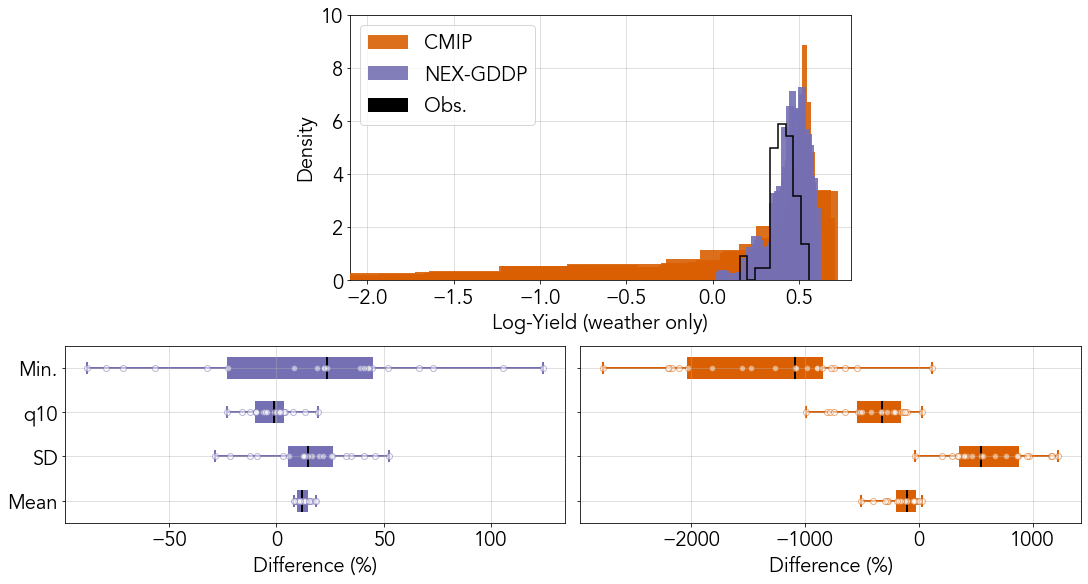

In [44]:
# Check for yield
fig = plt.figure(constrained_layout=True, figsize=(15,8))
gs = GridSpec(2, 4, figure=fig, height_ratios=[1.5,1], wspace=0.05)
ax1 = fig.add_subplot(gs[0, 1:-1])
ax2 = fig.add_subplot(gs[1, :2])
ax3 = fig.add_subplot(gs[1, 2:])

###############
# Plot style
###############
model_lw = 1.5
model_alpha = 0.9

# Hist plot
ax=ax1

# Legend
ax.hist(cmip_weather_av[cmip_models[0]], lw=model_lw, bins='fd', color='#d95f02', alpha=model_alpha, label='CMIP', density=True, zorder=10)
ax.hist(nex_weather_av[nex_models[0]], lw=model_lw, bins='fd', color='#7570b3', alpha=model_alpha, label='NEX-GDDP', density=True, zorder=10)
ax.hist([100], lw=model_lw, color='black', label='Obs.')
ax.set_xlim([-2.1, 0.8])
ax.legend()

# CMIP
for model in cmip_models[1:]:
    ax.hist(cmip_weather_av[model], lw=model_lw, bins='fd', color='#d95f02', alpha=model_alpha, label=None, density=True, zorder=10)

# NEX
for model in nex_models[1:]:
    ax.hist(nex_weather_av[model], lw=model_lw, bins='fd', color='#7570b3', alpha=model_alpha, label=None, density=True, zorder=10)

# GMFD
ax.hist(gmfd_av['weather'], lw=model_lw, bins='fd', histtype='step', color='black', label=None, density=True, zorder=10)

ax.set_ylim([0,10])
ax.grid(alpha=0.5, zorder=1)
ax.set_ylabel('Density')
ax.set_xlabel('Log-Yield (weather only)')

# Errors plot

# NEX
ax=ax2
nex_col = '#7570b3'
nex_bxplt = ax.boxplot([weather_nex_mean_error, weather_nex_sd_error, weather_nex_q10_error, weather_nex_min_error],
                       positions=[1,2,3,4],
                       patch_artist=True,
                       medianprops=dict(linewidth=2, color='black'),
                       boxprops=dict(linewidth=2, color=nex_col),
                       whiskerprops=dict(linewidth=2, color=nex_col),
                       capprops=dict(linewidth=2, color=nex_col),
                       showfliers=False,
                       whis=(0,100),
                       vert=False,
                       zorder=1)

for patch in nex_bxplt['boxes']:
        patch.set_facecolor(nex_col)
        
ax.scatter(weather_nex_min_error, [4 for model in nex_models], edgecolor=nex_col, facecolor='white', zorder=10, alpha=0.5)
ax.scatter(weather_nex_q10_error, [3 for model in nex_models], edgecolor=nex_col, facecolor='white', zorder=10, alpha=0.5)
ax.scatter(weather_nex_sd_error, [2 for model in nex_models], edgecolor=nex_col, facecolor='white', zorder=10, alpha=0.5)
ax.scatter(weather_nex_mean_error, [1 for model in nex_models], edgecolor=nex_col, facecolor='white', zorder=10, alpha=0.5)
        
ax.set_yticks([1,2,3,4])
ax.set_yticklabels(['Mean', 'SD', 'q10', 'Min.'])
ax.set_xlabel('Difference (%)')
ax.grid(alpha=0.5)

# CMIP
ax=ax3
cmip_col = '#d95f02'
cmip_bxplt = ax.boxplot([weather_cmip_mean_error, weather_cmip_sd_error, weather_cmip_q10_error, weather_cmip_min_error],
                        positions=[1,2,3,4],
                        patch_artist=True,
                        medianprops=dict(linewidth=2, color='black'),
                        boxprops=dict(linewidth=2, color=cmip_col),
                        whiskerprops=dict(linewidth=2, color=cmip_col),
                        capprops=dict(linewidth=2, color=cmip_col),
                        showfliers=False,
                        whis=(0,100),
                        vert=False,
                        zorder=1)

for patch in cmip_bxplt['boxes']:
        patch.set_facecolor(cmip_col)
        
ax.scatter(weather_cmip_min_error, [4 for model in cmip_models], edgecolor=cmip_col, facecolor='white', zorder=10, alpha=0.5)
ax.scatter(weather_cmip_q10_error, [3 for model in cmip_models], edgecolor=cmip_col, facecolor='white', zorder=10, alpha=0.5)
ax.scatter(weather_cmip_sd_error, [2 for model in cmip_models], edgecolor=cmip_col, facecolor='white', zorder=10, alpha=0.5)
ax.scatter(weather_cmip_mean_error, [1 for model in cmip_models], edgecolor=cmip_col, facecolor='white', zorder=10, alpha=0.5)

ax.set_xlabel('Difference (%)')
ax.set_yticklabels(['', '', '', ''])
ax.grid(alpha=0.5)

# plt.show()
plt.savefig('../../figs/new/SIfig_national_eval_unweighted.pdf')

## Figure 2

In [45]:
# Weather metrics
nex_weather_q10 = nex_weather.groupby('fips').quantile(q=0.1)
gmfd_weather_q10 = gmfd.groupby('fips').quantile(q=0.1)['weather']

nex_weather_mean = nex_weather.groupby('fips').mean()
gmfd_weather_mean = gmfd.groupby('fips').mean()['weather']

nex_weather_sd = nex_weather.groupby('fips').std()
gmfd_weather_sd = gmfd.groupby('fips').std()['weather']

nex_weather_min = nex_weather.groupby('fips').min()
gmfd_weather_min = gmfd.groupby('fips').min()['weather']

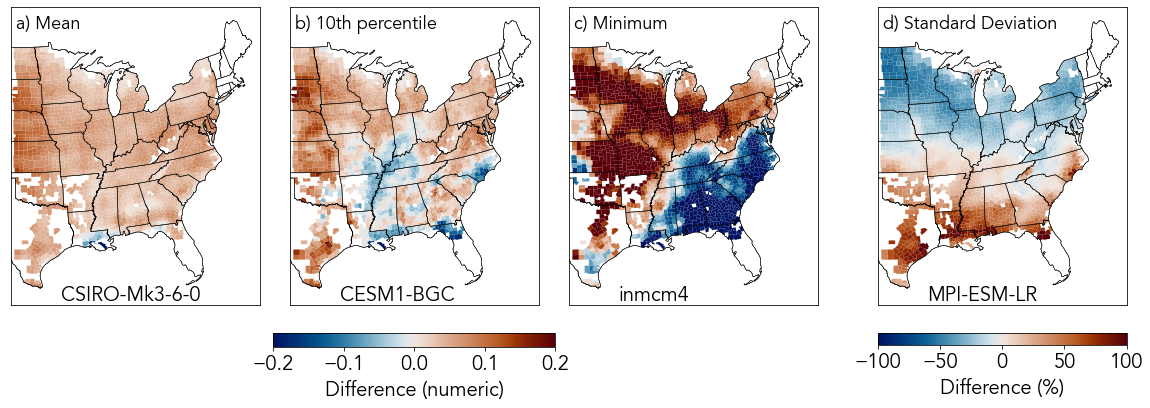

In [57]:
# NEX
gridspec = dict(wspace = 0.15, hspace=0.005, width_ratios=[1, 1, 1, 0., 1])
fig, axs = plt.subplots(1,5, figsize=(20,10), gridspec_kw=gridspec)
axs = axs.flatten()

axs[3].set_visible(False)

############################
## Top row
############################

vmin = -0.2
vmax = 0.2
cmap = vik_map

# Mean
ax=axs[0]
stat = 'mean'

plotdat = nex_weather_mean[weather_nex_mean_mpm] - gmfd_weather_mean
plotdat = pd.DataFrame({stat : plotdat}).loc[yield_fips]
plotdat = pd.merge(county_shp_plot, plotdat, on='fips', how='inner')
plotdat.plot(column=stat, ax=ax, legend=False, vmin=vmin, vmax=vmax, cmap=cmap)

states.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
coast.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
ax.tick_params(labelbottom=False, labelleft=False, color = 'white')
ax.set_xlim([-50000,2600000])
ax.set_ylim([-2300000, 874081])

ax.set_title(' a) Mean', loc = 'left', pad = -22, size=18)
ax.text(0.2, 0.015, weather_nex_mean_mpm, transform=ax.transAxes)


# q10
ax=axs[1]
stat = 'q10'

plotdat = nex_weather_q10[weather_nex_q10_mpm] - gmfd_weather_q10
plotdat = pd.DataFrame({stat : plotdat}).loc[yield_fips]
plotdat = pd.merge(county_shp_plot, plotdat, on='fips', how='inner')
plotdat.plot(column=stat, ax=ax, legend=False, vmin=vmin, vmax=vmax, cmap=cmap)

states.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
coast.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
ax.tick_params(labelbottom=False, labelleft=False, color = 'white')
ax.set_xlim([-50000,2600000])
ax.set_ylim([-2300000, 874081])
ax.set_title(' b) 10th percentile', loc = 'left', pad = -22, size=18)
ax.text(0.2, 0.015, weather_nex_q10_mpm, transform=ax.transAxes)

# Min
ax=axs[2]
stat = 'min'

plotdat = nex_weather_min[weather_nex_min_mpm] - gmfd_weather_min
plotdat = pd.DataFrame({stat : plotdat}).loc[yield_fips]
plotdat = pd.merge(county_shp_plot, plotdat, on='fips', how='inner')
plotdat.plot(column=stat, ax=ax, legend=False, vmin=vmin, vmax=vmax, cmap=cmap)

states.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
coast.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
ax.tick_params(labelbottom=False, labelleft=False, color = 'white')
ax.set_xlim([-50000,2600000])
ax.set_ylim([-2300000, 874081])
ax.set_title(' c) Minimum', loc = 'left', pad = -22, size=18)
ax.text(0.2, 0.015, weather_nex_min_mpm, transform=ax.transAxes)

# Colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
plt.colorbar(sm, orientation = 'horizontal', label = 'Difference (numeric)', shrink=0.35, ax=axs[:3], pad=0.05)

# SD
vmin = -100.
vmax = 100.
cmap = vik_map

ax=axs[4]
stat = 'sd'

plotdat = (nex_weather_sd[weather_nex_sd_mpm] - gmfd_weather_sd) / np.abs(gmfd_weather_sd) * 100.
plotdat = pd.DataFrame({stat : plotdat}).loc[yield_fips]
plotdat = pd.merge(county_shp_plot, plotdat, on='fips', how='inner')
plotdat.plot(column=stat, ax=ax, legend=False, vmin=vmin, vmax=vmax, cmap=cmap)

states.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
coast.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
ax.tick_params(labelbottom=False, labelleft=False, color = 'white')
ax.set_xlim([-50000,2600000])
ax.set_ylim([-2300000, 874081])
ax.set_title(' d) Standard Deviation', loc = 'left', pad = -22, size=18)
ax.text(0.2, 0.015, weather_nex_sd_mpm, transform=ax.transAxes)

# Colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
plt.colorbar(sm, orientation = 'horizontal', label = 'Difference (%)', ax=axs[4], pad=0.05)

plt.savefig('../../figs/new/Figure2.png', dpi=600)

### Supplementary Figure: CMIP-equivalent of Figure 2

In [58]:
# Weather metrics
cmip_weather_q10 = cmip_weather.groupby('fips').quantile(q=0.1)
gmfd_weather_q10 = gmfd.groupby('fips').quantile(q=0.1)['weather']

cmip_weather_mean = cmip_weather.groupby('fips').mean()
gmfd_weather_mean = gmfd.groupby('fips').mean()['weather']

cmip_weather_sd = cmip_weather.groupby('fips').std()
gmfd_weather_sd = gmfd.groupby('fips').std()['weather']

cmip_weather_min = cmip_weather.groupby('fips').min()
gmfd_weather_min = gmfd.groupby('fips').min()['weather']

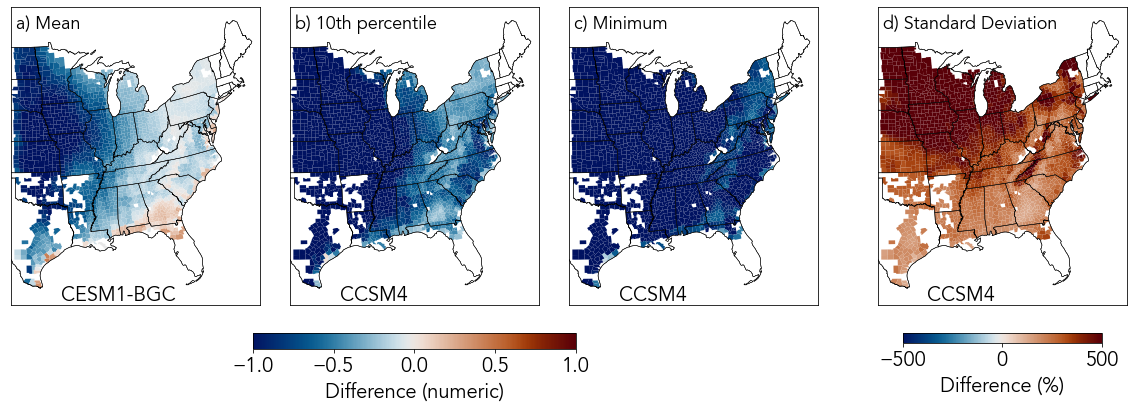

In [60]:
# CMIP
gridspec = dict(wspace = 0.15, hspace=0.005, width_ratios=[1, 1, 1, 0., 1])
fig, axs = plt.subplots(1,5, figsize=(20,10), gridspec_kw=gridspec)
axs = axs.flatten()

axs[3].set_visible(False)

############################
## Top row
############################

vmin = -1.
vmax = 1.
cmap = vik_map

# Mean
ax=axs[0]
stat = 'mean'

plotdat = cmip_weather_mean[weather_cmip_mean_mpm] - gmfd_weather_mean
plotdat = pd.DataFrame({stat : plotdat}).loc[yield_fips]
plotdat = pd.merge(county_shp_plot, plotdat, on='fips', how='inner')
plotdat.plot(column=stat, ax=ax, legend=False, vmin=vmin, vmax=vmax, cmap=cmap)

states.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
coast.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
ax.tick_params(labelbottom=False, labelleft=False, color = 'white')
ax.set_xlim([-50000,2600000])
ax.set_ylim([-2300000, 874081])
ax.set_title(' a) Mean', loc = 'left', pad = -22, size=18)
ax.text(0.2, 0.015, weather_cmip_mean_mpm, transform=ax.transAxes)


# q10
ax=axs[1]
stat = 'q10'

plotdat = cmip_weather_q10[weather_cmip_q10_mpm] - gmfd_weather_q10
plotdat = pd.DataFrame({stat : plotdat}).loc[yield_fips]
plotdat = pd.merge(county_shp_plot, plotdat, on='fips', how='inner')
plotdat.plot(column=stat, ax=ax, legend=False, vmin=vmin, vmax=vmax, cmap=cmap)

states.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
coast.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
ax.tick_params(labelbottom=False, labelleft=False, color = 'white')
ax.set_xlim([-50000,2600000])
ax.set_ylim([-2300000, 874081])
ax.set_title(' b) 10th percentile', loc = 'left', pad = -22, size=18)
ax.text(0.2, 0.015, weather_cmip_q10_mpm, transform=ax.transAxes)

# q10
ax=axs[2]
stat = 'min'

plotdat = cmip_weather_min[weather_cmip_min_mpm] - gmfd_weather_min
plotdat = pd.DataFrame({stat : plotdat}).loc[yield_fips]
plotdat = pd.merge(county_shp_plot, plotdat, on='fips', how='inner')
plotdat.plot(column=stat, ax=ax, legend=False, vmin=vmin, vmax=vmax, cmap=cmap)

states.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
coast.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
ax.tick_params(labelbottom=False, labelleft=False, color = 'white')
ax.set_xlim([-50000,2600000])
ax.set_ylim([-2300000, 874081])
ax.set_title(' c) Minimum', loc = 'left', pad = -22, size=18)
ax.text(0.2, 0.015, weather_cmip_min_mpm, transform=ax.transAxes)

# Colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
plt.colorbar(sm, orientation = 'horizontal', label = 'Difference (numeric)', shrink=0.4, ax=axs[:3], pad=0.05)

# SD
vmin = -500.
vmax = 500.
cmap = vik_map

ax=axs[4]
stat = 'sd'

plotdat = (cmip_weather_sd[weather_cmip_sd_mpm] - gmfd_weather_sd) / np.abs(gmfd_weather_sd) * 100.
plotdat = pd.DataFrame({stat : plotdat}).loc[yield_fips]
plotdat = pd.merge(county_shp_plot, plotdat, on='fips', how='inner')
plotdat.plot(column=stat, ax=ax, legend=False, vmin=vmin, vmax=vmax, cmap=cmap)

states.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
coast.geometry.boundary.plot(ax=ax, linewidth=0.5, edgecolor="black", color=None)
ax.tick_params(labelbottom=False, labelleft=False, color = 'white')
ax.set_xlim([-50000,2600000])
ax.set_ylim([-2300000, 874081])
ax.set_title(' d) Standard Deviation', loc = 'left', pad = -22, size=18)
ax.text(0.2, 0.015, weather_cmip_sd_mpm, transform=ax.transAxes)

# Colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
plt.colorbar(sm, orientation = 'horizontal', label = 'Difference (%)', shrink=0.8, ax=axs[4], pad=0.05)

plt.savefig('../../figs/new/SIfig_CMIP_fig2_eq.png', dpi=600)
# plt.show()

## Figure 3

In [61]:
# GDD metrics
nex_gdd_q10 = nex_gdd.groupby('fips').quantile(q=0.1)
gmfd_gdd_q10 = gmfd.groupby('fips').quantile(q=0.1)['gdd']

nex_gdd_mean = nex_gdd.groupby('fips').mean()
gmfd_gdd_mean = gmfd.groupby('fips').mean()['gdd']

nex_gdd_sd = nex_gdd.groupby('fips').std()
gmfd_gdd_sd = gmfd.groupby('fips').std()['gdd']

nex_gdd_min = nex_gdd.groupby('fips').min()
gmfd_gdd_min = gmfd.groupby('fips').min()['gdd']

# EDD metrics
nex_edd_q90 = nex_edd.groupby('fips').quantile(q=0.9)
gmfd_edd_q90 = gmfd.groupby('fips').quantile(q=0.9)['edd']

nex_edd_mean = nex_edd.groupby('fips').mean()
gmfd_edd_mean = gmfd.groupby('fips').mean()['edd']

nex_edd_sd = nex_edd.groupby('fips').std()
gmfd_edd_sd = gmfd.groupby('fips').std()['edd']

nex_edd_max = nex_edd.groupby('fips').max()
gmfd_edd_max = gmfd.groupby('fips').max()['edd']

# Prcp metrics
nex_prcp_q10 = nex_prcp.groupby('fips').quantile(q=0.1)
gmfd_prcp_q10 = gmfd.groupby('fips').quantile(q=0.1)['prcp']

nex_prcp_mean = nex_prcp.groupby('fips').mean()
gmfd_prcp_mean = gmfd.groupby('fips').mean()['prcp']

nex_prcp_sd = nex_prcp.groupby('fips').std()
gmfd_prcp_sd = gmfd.groupby('fips').std()['prcp']

nex_prcp_min = nex_prcp.groupby('fips').min()
gmfd_prcp_min = gmfd.groupby('fips').min()['prcp']

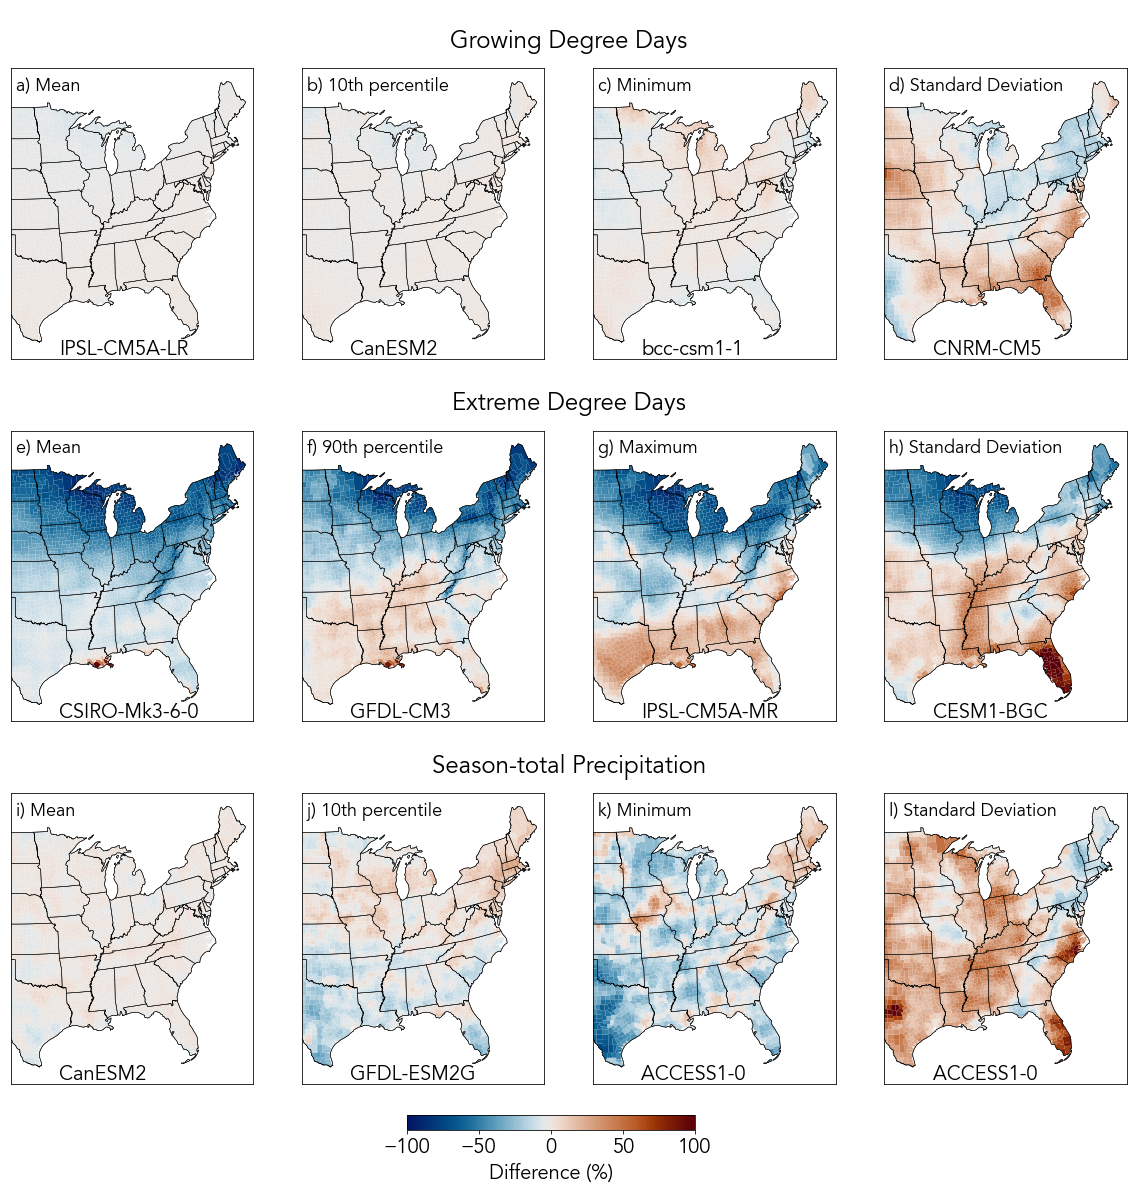

In [62]:
fig = plt.figure(figsize=(20,20))
gs = GridSpec(6, 4, figure=fig, height_ratios=[5,30,5,30,5,30], hspace=0.)
title_ax1 = fig.add_subplot(gs[0, :])
title_ax2 = fig.add_subplot(gs[2, :])
title_ax3 = fig.add_subplot(gs[4, :])

title_ax1.set_title('Growing Degree Days', y=0.1)
title_ax1.axis('off')
title_ax2.set_title('Extreme Degree Days', y=0.1)
title_ax2.axis('off')
title_ax3.set_title('Season-total Precipitation', y=0.1)
title_ax3.axis('off')

vmin = -100.
vmax = 100.

############################
## Top row (GDD)
############################

# Add subplots
ax10 = fig.add_subplot(gs[1,0])
ax11 = fig.add_subplot(gs[1,1])
ax12 = fig.add_subplot(gs[1,2])
ax13 = fig.add_subplot(gs[1,3])

ax30 = fig.add_subplot(gs[3,0])
ax31 = fig.add_subplot(gs[3,1])
ax32 = fig.add_subplot(gs[3,2])
ax33 = fig.add_subplot(gs[3,3])

ax50 = fig.add_subplot(gs[5,0])
ax51 = fig.add_subplot(gs[5,1])
ax52 = fig.add_subplot(gs[5,2])
ax53 = fig.add_subplot(gs[5,3])

# cbar_ax = fig.add_subplot(gs[6,:])
# cbar_ax.axis('off')

# Mean
stat = 'mean'

plotdat = (nex_gdd_mean[gdd_nex_mean_mpm] - gmfd_gdd_mean) / np.abs(gmfd_gdd_mean) * 100.
plotdat = pd.DataFrame({stat : plotdat})
plotdat = pd.merge(county_shp_plot, plotdat, on='fips', how='inner')
plotdat.plot(column=stat, ax=ax10, legend=False, vmin=vmin, vmax=vmax, cmap=cmap)

states.geometry.boundary.plot(ax=ax10, linewidth=0.5, edgecolor="black", color=None)
coast.geometry.boundary.plot(ax=ax10, linewidth=0.5, edgecolor="black", color=None)
ax10.tick_params(labelbottom=False, labelleft=False, color = 'white')
ax10.set_xlim([-50000,2600000])
ax10.set_ylim([-2300000, 874081])
ax10.set_title(' a) Mean', loc = 'left', pad = -22, size=18)
ax10.text(0.2, 0.015, gdd_nex_mean_mpm, transform=ax10.transAxes)

# q10
stat = 'q10'

plotdat = (nex_gdd_q10[gdd_nex_q10_mpm] - gmfd_gdd_q10) / np.abs(gmfd_gdd_q10) * 100.
plotdat = pd.DataFrame({stat : plotdat})
plotdat = pd.merge(county_shp_plot, plotdat, on='fips', how='inner')
plotdat.plot(column=stat, ax=ax11, legend=False, vmin=vmin, vmax=vmax, cmap=cmap)

states.geometry.boundary.plot(ax=ax11, linewidth=0.5, edgecolor="black", color=None)
coast.geometry.boundary.plot(ax=ax11, linewidth=0.5, edgecolor="black", color=None)
ax11.tick_params(labelbottom=False, labelleft=False, color = 'white')
ax11.set_xlim([-50000,2600000])
ax11.set_ylim([-2300000, 874081])
ax11.set_title(' b) 10th percentile', loc = 'left', pad = -22, size=18)
ax11.text(0.2, 0.015, gdd_nex_q10_mpm, transform=ax11.transAxes)

# Min
stat = 'min'

plotdat = (nex_gdd_min[gdd_nex_min_mpm] - gmfd_gdd_min) / np.abs(gmfd_gdd_min) * 100.
plotdat = pd.DataFrame({stat : plotdat})
plotdat = pd.merge(county_shp_plot, plotdat, on='fips', how='inner')
plotdat.plot(column=stat, ax=ax12, legend=False, vmin=vmin, vmax=vmax, cmap=cmap)

states.geometry.boundary.plot(ax=ax12, linewidth=0.5, edgecolor="black", color=None)
coast.geometry.boundary.plot(ax=ax12, linewidth=0.5, edgecolor="black", color=None)
ax12.tick_params(labelbottom=False, labelleft=False, color = 'white')
ax12.set_xlim([-50000,2600000])
ax12.set_ylim([-2300000, 874081])
ax12.set_title(' c) Minimum', loc = 'left', pad = -22, size=18)
ax12.text(0.2, 0.015, gdd_nex_min_mpm, transform=ax12.transAxes)

# SD
stat = 'sd'

plotdat = (nex_gdd_sd[gdd_nex_sd_mpm] - gmfd_gdd_sd) / np.abs(gmfd_gdd_sd) * 100.
plotdat = pd.DataFrame({stat : plotdat})
plotdat = pd.merge(county_shp_plot, plotdat, on='fips', how='inner')
plotdat.plot(column=stat, ax=ax13, legend=False, vmin=vmin, vmax=vmax, cmap=cmap)

states.geometry.boundary.plot(ax=ax13, linewidth=0.5, edgecolor="black", color=None)
coast.geometry.boundary.plot(ax=ax13, linewidth=0.5, edgecolor="black", color=None)
ax13.tick_params(labelbottom=False, labelleft=False, color = 'white')
ax13.set_xlim([-50000,2600000])
ax13.set_ylim([-2300000, 874081])
ax13.set_title(' d) Standard Deviation', loc = 'left', pad = -22, size=18)
ax13.text(0.2, 0.015, gdd_nex_sd_mpm, transform=ax13.transAxes)

############################
## Middle row (EDD)
############################

# Mean
stat = 'mean'

plotdat = (nex_edd_mean[edd_nex_mean_mpm] - gmfd_edd_mean) / np.abs(gmfd_edd_mean) * 100.
plotdat = pd.DataFrame({stat : plotdat})
plotdat = pd.merge(county_shp_plot, plotdat, on='fips', how='inner')
plotdat.plot(column=stat, ax=ax30, legend=False, vmin=vmin, vmax=vmax, cmap=cmap)

states.geometry.boundary.plot(ax=ax30, linewidth=0.5, edgecolor="black", color=None)
coast.geometry.boundary.plot(ax=ax30, linewidth=0.5, edgecolor="black", color=None)
ax30.tick_params(labelbottom=False, labelleft=False, color = 'white')
ax30.set_xlim([-50000,2600000])
ax30.set_ylim([-2300000, 874081])
ax30.set_title(' e) Mean', loc = 'left', pad = -22, size=18)
ax30.text(0.2, 0.015, edd_nex_mean_mpm, transform=ax30.transAxes)


# q90
stat = 'q90'

plotdat = (nex_edd_q90[edd_nex_q90_mpm] - gmfd_edd_q90) / np.abs(gmfd_edd_q90) * 100.
plotdat = pd.DataFrame({stat : plotdat})
plotdat = pd.merge(county_shp_plot, plotdat, on='fips', how='inner')
plotdat.plot(column=stat, ax=ax31, legend=False, vmin=vmin, vmax=vmax, cmap=cmap)

states.geometry.boundary.plot(ax=ax31, linewidth=0.5, edgecolor="black", color=None)
coast.geometry.boundary.plot(ax=ax31, linewidth=0.5, edgecolor="black", color=None)
ax31.tick_params(labelbottom=False, labelleft=False, color = 'white')
ax31.set_xlim([-50000,2600000])
ax31.set_ylim([-2300000, 874081])
ax31.set_title(' f) 90th percentile', loc = 'left', pad = -22, size=18)
ax31.text(0.2, 0.015, edd_nex_q90_mpm, transform=ax31.transAxes)

# Min
stat = 'max'

plotdat = (nex_edd_max[edd_nex_max_mpm] - gmfd_edd_max) / np.abs(gmfd_edd_max) * 100.
plotdat = pd.DataFrame({stat : plotdat})
plotdat = pd.merge(county_shp_plot, plotdat, on='fips', how='inner')
plotdat.plot(column=stat, ax=ax32, legend=False, vmin=vmin, vmax=vmax, cmap=cmap)

states.geometry.boundary.plot(ax=ax32, linewidth=0.5, edgecolor="black", color=None)
coast.geometry.boundary.plot(ax=ax32, linewidth=0.5, edgecolor="black", color=None)
ax32.tick_params(labelbottom=False, labelleft=False, color = 'white')
ax32.set_xlim([-50000,2600000])
ax32.set_ylim([-2300000, 874081])
ax32.set_title(' g) Maximum', loc = 'left', pad = -22, size=18)
ax32.text(0.2, 0.015, edd_nex_max_mpm, transform=ax32.transAxes)

# SD
stat = 'sd'

plotdat = (nex_edd_sd[edd_nex_sd_mpm] - gmfd_edd_sd) / np.abs(gmfd_edd_sd) * 100.
plotdat = pd.DataFrame({stat : plotdat})
plotdat = pd.merge(county_shp_plot, plotdat, on='fips', how='inner')
plotdat.plot(column=stat, ax=ax33, legend=False, vmin=vmin, vmax=vmax, cmap=cmap)

states.geometry.boundary.plot(ax=ax33, linewidth=0.5, edgecolor="black", color=None)
coast.geometry.boundary.plot(ax=ax33, linewidth=0.5, edgecolor="black", color=None)
ax33.tick_params(labelbottom=False, labelleft=False, color = 'white')
ax33.set_xlim([-50000,2600000])
ax33.set_ylim([-2300000, 874081])
ax33.set_title(' h) Standard Deviation', loc = 'left', pad = -22, size=18)
ax33.text(0.2, 0.015, edd_nex_sd_mpm, transform=ax33.transAxes)

############################
## Bottom row (prcp)
############################

# Mean
stat = 'mean'

plotdat = (nex_prcp_mean[prcp_nex_mean_mpm] - gmfd_prcp_mean) / np.abs(gmfd_prcp_mean) * 100.
plotdat = pd.DataFrame({stat : plotdat})
plotdat = pd.merge(county_shp_plot, plotdat, on='fips', how='inner')
plotdat.plot(column=stat, ax=ax50, legend=False, vmin=vmin, vmax=vmax, cmap=cmap)

states.geometry.boundary.plot(ax=ax50, linewidth=0.5, edgecolor="black", color=None)
coast.geometry.boundary.plot(ax=ax50, linewidth=0.5, edgecolor="black", color=None)
ax50.tick_params(labelbottom=False, labelleft=False, color = 'white')
ax50.set_xlim([-50000,2600000])
ax50.set_ylim([-2300000, 874081])
ax50.set_title(' i) Mean', loc = 'left', pad = -22, size=18)
ax50.text(0.2, 0.015, prcp_nex_mean_mpm, transform=ax50.transAxes)


# q10
stat = 'q10'

plotdat = (nex_prcp_q10[prcp_nex_q10_mpm] - gmfd_prcp_q10) / np.abs(gmfd_prcp_q10) * 100.
plotdat = pd.DataFrame({stat : plotdat})
plotdat = pd.merge(county_shp_plot, plotdat, on='fips', how='inner')
plotdat.plot(column=stat, ax=ax51, legend=False, vmin=vmin, vmax=vmax, cmap=cmap)

states.geometry.boundary.plot(ax=ax51, linewidth=0.5, edgecolor="black", color=None)
coast.geometry.boundary.plot(ax=ax51, linewidth=0.5, edgecolor="black", color=None)
ax51.tick_params(labelbottom=False, labelleft=False, color = 'white')
ax51.set_xlim([-50000,2600000])
ax51.set_ylim([-2300000, 874081])
ax51.set_title(' j) 10th percentile', loc = 'left', pad = -22, size=18)
ax51.text(0.2, 0.015, prcp_nex_q10_mpm, transform=ax51.transAxes)

# Min
stat = 'min'

plotdat = (nex_prcp_min[prcp_nex_min_mpm] - gmfd_prcp_min) / np.abs(gmfd_prcp_min) * 100.
plotdat = pd.DataFrame({stat : plotdat})
plotdat = pd.merge(county_shp_plot, plotdat, on='fips', how='inner')
plotdat.plot(column=stat, ax=ax52, legend=False, vmin=vmin, vmax=vmax, cmap=cmap)

states.geometry.boundary.plot(ax=ax52, linewidth=0.5, edgecolor="black", color=None)
coast.geometry.boundary.plot(ax=ax52, linewidth=0.5, edgecolor="black", color=None)
ax52.tick_params(labelbottom=False, labelleft=False, color = 'white')
ax52.set_xlim([-50000,2600000])
ax52.set_ylim([-2300000, 874081])
ax52.set_title(' k) Minimum', loc = 'left', pad = -22, size=18)
ax52.text(0.2, 0.015, prcp_nex_min_mpm, transform=ax52.transAxes)

# SD
stat = 'sd'
plotdat = (nex_prcp_sd[prcp_nex_sd_mpm] - gmfd_prcp_sd) / np.abs(gmfd_prcp_sd) * 100.
plotdat = pd.DataFrame({stat : plotdat})
plotdat = pd.merge(county_shp_plot, plotdat, on='fips', how='inner')
plotdat.plot(column=stat, ax=ax53, legend=False, vmin=vmin, vmax=vmax, cmap=cmap)

states.geometry.boundary.plot(ax=ax53, linewidth=0.5, edgecolor="black", color=None)
coast.geometry.boundary.plot(ax=ax53, linewidth=0.5, edgecolor="black", color=None)
ax53.tick_params(labelbottom=False, labelleft=False, color = 'white')
ax53.set_xlim([-50000,2600000])
ax53.set_ylim([-2300000, 874081])
ax53.set_title(' l) Standard Deviation', loc = 'left', pad = -22, size=18)
ax53.text(0.2, 0.015, prcp_nex_sd_mpm, transform=ax53.transAxes)

cbaxes = fig.add_axes([0.4, 0.1, 0.2, 0.01]) 
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
plt.colorbar(sm, orientation = 'horizontal', label = 'Difference (%)', shrink=0.5, cax=cbaxes)

plt.savefig('../../figs/new/Figure3.png', dpi=600)
# plt.show()

### Supplementary Figure: CMIP-equivalent of Figure 3

In [63]:
# GDD metrics
cmip_gdd_q10 = cmip_gdd.groupby('fips').quantile(q=0.1)
gmfd_gdd_q10 = gmfd.groupby('fips').quantile(q=0.1)['gdd']

cmip_gdd_mean = cmip_gdd.groupby('fips').mean()
gmfd_gdd_mean = gmfd.groupby('fips').mean()['gdd']

cmip_gdd_sd = cmip_gdd.groupby('fips').std()
gmfd_gdd_sd = gmfd.groupby('fips').std()['gdd']

cmip_gdd_min = cmip_gdd.groupby('fips').min()
gmfd_gdd_min = gmfd.groupby('fips').min()['gdd']

# EDD metrics
cmip_edd_q90 = cmip_edd.groupby('fips').quantile(q=0.9)
gmfd_edd_q90 = gmfd.groupby('fips').quantile(q=0.9)['edd']

cmip_edd_mean = cmip_edd.groupby('fips').mean()
gmfd_edd_mean = gmfd.groupby('fips').mean()['edd']

cmip_edd_sd = cmip_edd.groupby('fips').std()
gmfd_edd_sd = gmfd.groupby('fips').std()['edd']

cmip_edd_max = cmip_edd.groupby('fips').max()
gmfd_edd_max = gmfd.groupby('fips').max()['edd']

# Prcp metrics
cmip_prcp_q10 = cmip_prcp.groupby('fips').quantile(q=0.1)
gmfd_prcp_q10 = gmfd.groupby('fips').quantile(q=0.1)['prcp']

cmip_prcp_mean = cmip_prcp.groupby('fips').mean()
gmfd_prcp_mean = gmfd.groupby('fips').mean()['prcp']

cmip_prcp_sd = cmip_prcp.groupby('fips').std()
gmfd_prcp_sd = gmfd.groupby('fips').std()['prcp']

cmip_prcp_min = cmip_prcp.groupby('fips').min()
gmfd_prcp_min = gmfd.groupby('fips').min()['prcp']

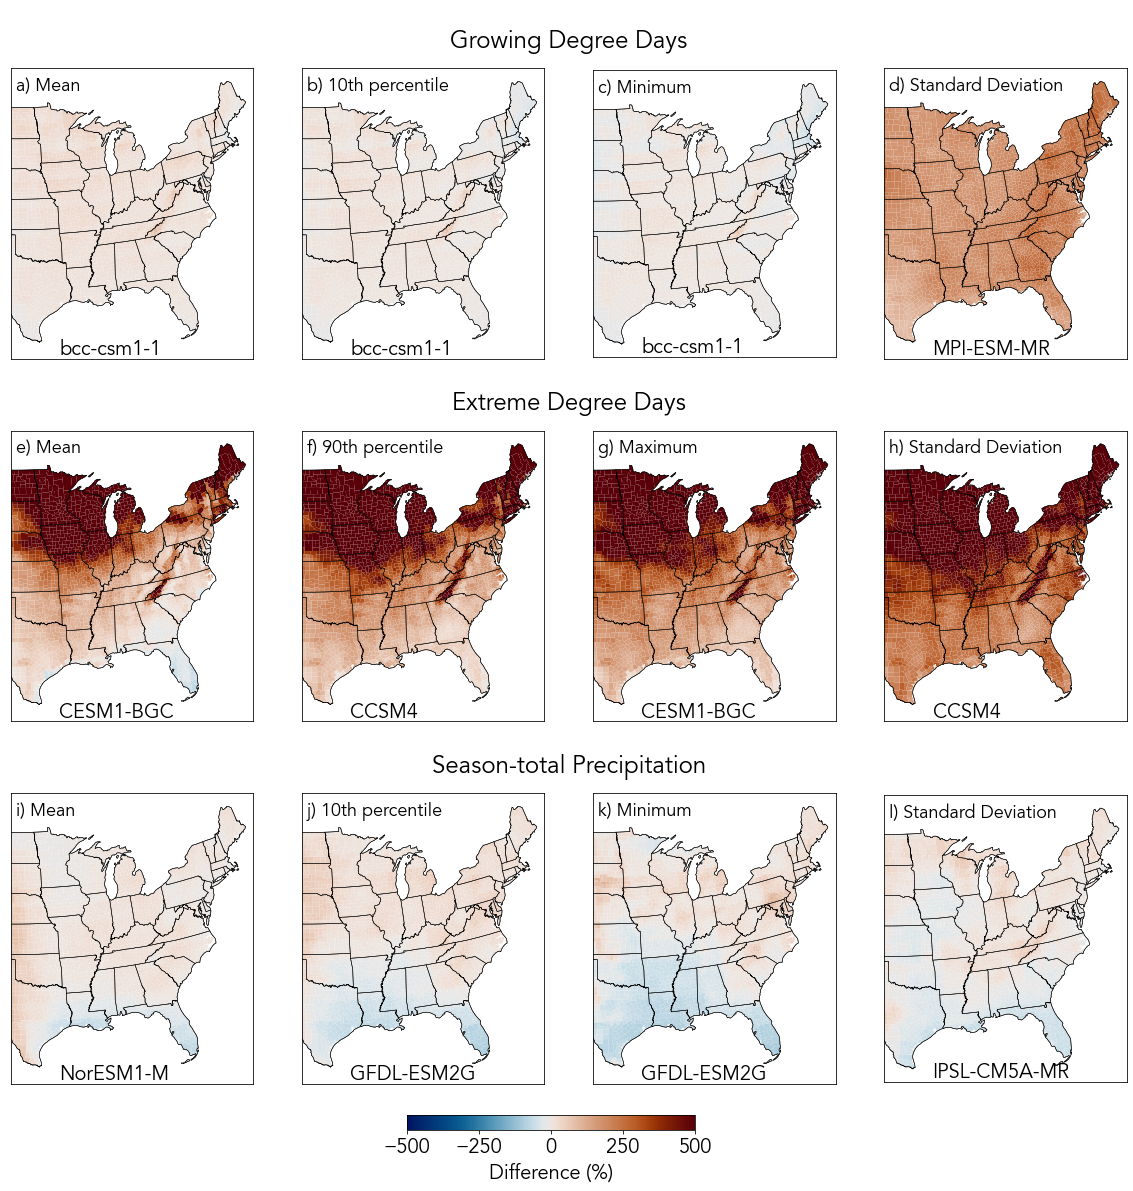

In [64]:
fig = plt.figure(figsize=(20,20))
gs = GridSpec(6, 4, figure=fig, height_ratios=[5,30,5,30,5,30], hspace=0.)
title_ax1 = fig.add_subplot(gs[0, :])
title_ax2 = fig.add_subplot(gs[2, :])
title_ax3 = fig.add_subplot(gs[4, :])

title_ax1.set_title('Growing Degree Days', y=0.1)
title_ax1.axis('off')
title_ax2.set_title('Extreme Degree Days', y=0.1)
title_ax2.axis('off')
title_ax3.set_title('Season-total Precipitation', y=0.1)
title_ax3.axis('off')

vmin = -500.
vmax = 500.

############################
## Top row (GDD)
############################

# Add subplots
ax10 = fig.add_subplot(gs[1,0])
ax11 = fig.add_subplot(gs[1,1])
ax12 = fig.add_subplot(gs[1,2])
ax13 = fig.add_subplot(gs[1,3])

ax30 = fig.add_subplot(gs[3,0])
ax31 = fig.add_subplot(gs[3,1])
ax32 = fig.add_subplot(gs[3,2])
ax33 = fig.add_subplot(gs[3,3])

ax50 = fig.add_subplot(gs[5,0])
ax51 = fig.add_subplot(gs[5,1])
ax52 = fig.add_subplot(gs[5,2])
ax53 = fig.add_subplot(gs[5,3])

# cbar_ax = fig.add_subplot(gs[6,:])
# cbar_ax.axis('off')

# Mean
stat = 'mean'

plotdat = (cmip_gdd_mean[gdd_cmip_mean_mpm] - gmfd_gdd_mean) / np.abs(gmfd_gdd_mean) * 100.
plotdat = pd.DataFrame({stat : plotdat})
plotdat = pd.merge(county_shp_plot, plotdat, on='fips', how='inner')
plotdat.plot(column=stat, ax=ax10, legend=False, vmin=vmin, vmax=vmax, cmap=cmap)

states.geometry.boundary.plot(ax=ax10, linewidth=0.5, edgecolor="black", color=None)
coast.geometry.boundary.plot(ax=ax10, linewidth=0.5, edgecolor="black", color=None)
ax10.tick_params(labelbottom=False, labelleft=False, color = 'white')
ax10.set_xlim([-50000,2600000])
ax10.set_ylim([-2300000, 874081])
ax10.set_title(' a) Mean', loc = 'left', pad = -22, size=18)
ax10.text(0.2, 0.015, gdd_cmip_mean_mpm, transform=ax10.transAxes)

# q10
stat = 'q10'

plotdat = (cmip_gdd_q10[gdd_cmip_q10_mpm] - gmfd_gdd_q10) / np.abs(gmfd_gdd_q10) * 100.
plotdat = pd.DataFrame({stat : plotdat})
plotdat = pd.merge(county_shp_plot, plotdat, on='fips', how='inner')
plotdat.plot(column=stat, ax=ax11, legend=False, vmin=vmin, vmax=vmax, cmap=cmap)

states.geometry.boundary.plot(ax=ax11, linewidth=0.5, edgecolor="black", color=None)
coast.geometry.boundary.plot(ax=ax11, linewidth=0.5, edgecolor="black", color=None)
ax11.tick_params(labelbottom=False, labelleft=False, color = 'white')
ax11.set_xlim([-50000,2600000])
ax11.set_ylim([-2300000, 874081])
ax11.set_title(' b) 10th percentile', loc = 'left', pad = -22, size=18)
ax11.text(0.2, 0.015, gdd_cmip_q10_mpm, transform=ax11.transAxes)

# Min
stat = 'min'

plotdat = (cmip_gdd_min[gdd_cmip_min_mpm] - gmfd_gdd_min) / np.abs(gmfd_gdd_min) * 100.
plotdat = pd.DataFrame({stat : plotdat})
plotdat = pd.merge(county_shp_plot, plotdat, on='fips', how='inner')
plotdat.plot(column=stat, ax=ax12, legend=False, vmin=vmin, vmax=vmax, cmap=cmap)

states.geometry.boundary.plot(ax=ax12, linewidth=0.5, edgecolor="black", color=None)
coast.geometry.boundary.plot(ax=ax12, linewidth=0.5, edgecolor="black", color=None)
ax12.tick_params(labelbottom=False, labelleft=False, color = 'white')
ax12.set_xlim([-50000,2600000])
ax12.set_title(' c) Minimum', loc = 'left', pad = -22, size=18)
ax12.text(0.2, 0.015, gdd_cmip_min_mpm, transform=ax12.transAxes)

# SD
stat = 'sd'

plotdat = (cmip_gdd_sd[gdd_cmip_sd_mpm] - gmfd_gdd_sd) / np.abs(gmfd_gdd_sd) * 100.
plotdat = pd.DataFrame({stat : plotdat})
plotdat = pd.merge(county_shp_plot, plotdat, on='fips', how='inner')
plotdat.plot(column=stat, ax=ax13, legend=False, vmin=vmin, vmax=vmax, cmap=cmap)

states.geometry.boundary.plot(ax=ax13, linewidth=0.5, edgecolor="black", color=None)
coast.geometry.boundary.plot(ax=ax13, linewidth=0.5, edgecolor="black", color=None)
ax13.tick_params(labelbottom=False, labelleft=False, color = 'white')
ax13.set_xlim([-50000,2600000])
ax13.set_ylim([-2300000, 874081])
ax13.set_title(' d) Standard Deviation', loc = 'left', pad = -22, size=18)
ax13.text(0.2, 0.015, gdd_cmip_sd_mpm, transform=ax13.transAxes)

############################
## Middle row (EDD)
############################

# Mean
stat = 'mean'

plotdat = (cmip_edd_mean[edd_cmip_mean_mpm] - gmfd_edd_mean) / np.abs(gmfd_edd_mean) * 100.
plotdat = pd.DataFrame({stat : plotdat})
plotdat = pd.merge(county_shp_plot, plotdat, on='fips', how='inner')
plotdat.plot(column=stat, ax=ax30, legend=False, vmin=vmin, vmax=vmax, cmap=cmap)

states.geometry.boundary.plot(ax=ax30, linewidth=0.5, edgecolor="black", color=None)
coast.geometry.boundary.plot(ax=ax30, linewidth=0.5, edgecolor="black", color=None)
ax30.tick_params(labelbottom=False, labelleft=False, color = 'white')
ax30.set_xlim([-50000,2600000])
ax30.set_ylim([-2300000, 874081])
ax30.set_title(' e) Mean', loc = 'left', pad = -22, size=18)
ax30.text(0.2, 0.015, edd_cmip_mean_mpm, transform=ax30.transAxes)


# q90
stat = 'q90'

plotdat = (cmip_edd_q90[edd_cmip_q90_mpm] - gmfd_edd_q90) / np.abs(gmfd_edd_q90) * 100.
plotdat = pd.DataFrame({stat : plotdat})
plotdat = pd.merge(county_shp_plot, plotdat, on='fips', how='inner')
plotdat.plot(column=stat, ax=ax31, legend=False, vmin=vmin, vmax=vmax, cmap=cmap)

states.geometry.boundary.plot(ax=ax31, linewidth=0.5, edgecolor="black", color=None)
coast.geometry.boundary.plot(ax=ax31, linewidth=0.5, edgecolor="black", color=None)
ax31.tick_params(labelbottom=False, labelleft=False, color = 'white')
ax31.set_xlim([-50000,2600000])
ax31.set_ylim([-2300000, 874081])
ax31.set_title(' f) 90th percentile', loc = 'left', pad = -22, size=18)
ax31.text(0.2, 0.015, edd_cmip_q90_mpm, transform=ax31.transAxes)

# Min
stat = 'max'

plotdat = (cmip_edd_max[edd_cmip_max_mpm] - gmfd_edd_max) / np.abs(gmfd_edd_max) * 100.
plotdat = pd.DataFrame({stat : plotdat})
plotdat = pd.merge(county_shp_plot, plotdat, on='fips', how='inner')
plotdat.plot(column=stat, ax=ax32, legend=False, vmin=vmin, vmax=vmax, cmap=cmap)

states.geometry.boundary.plot(ax=ax32, linewidth=0.5, edgecolor="black", color=None)
coast.geometry.boundary.plot(ax=ax32, linewidth=0.5, edgecolor="black", color=None)
ax32.tick_params(labelbottom=False, labelleft=False, color = 'white')
ax32.set_xlim([-50000,2600000])
ax32.set_ylim([-2300000, 874081])
ax32.set_title(' g) Maximum', loc = 'left', pad = -22, size=18)
ax32.text(0.2, 0.015, edd_cmip_max_mpm, transform=ax32.transAxes)

# SD
stat = 'sd'

plotdat = (cmip_edd_sd[edd_cmip_sd_mpm] - gmfd_edd_sd) / np.abs(gmfd_edd_sd) * 100.
plotdat = pd.DataFrame({stat : plotdat})
plotdat = pd.merge(county_shp_plot, plotdat, on='fips', how='inner')
plotdat.plot(column=stat, ax=ax33, legend=False, vmin=vmin, vmax=vmax, cmap=cmap)

states.geometry.boundary.plot(ax=ax33, linewidth=0.5, edgecolor="black", color=None)
coast.geometry.boundary.plot(ax=ax33, linewidth=0.5, edgecolor="black", color=None)
ax33.tick_params(labelbottom=False, labelleft=False, color = 'white')
ax33.set_xlim([-50000,2600000])
ax33.set_ylim([-2300000, 874081])
ax33.set_title(' h) Standard Deviation', loc = 'left', pad = -22, size=18)
ax33.text(0.2, 0.015, edd_cmip_sd_mpm, transform=ax33.transAxes)

############################
## Bottom row (prcp)
############################

# Mean
stat = 'mean'

plotdat = (cmip_prcp_mean[prcp_cmip_mean_mpm] - gmfd_prcp_mean) / np.abs(gmfd_prcp_mean) * 100.
plotdat = pd.DataFrame({stat : plotdat})
plotdat = pd.merge(county_shp_plot, plotdat, on='fips', how='inner')
plotdat.plot(column=stat, ax=ax50, legend=False, vmin=vmin, vmax=vmax, cmap=cmap)

states.geometry.boundary.plot(ax=ax50, linewidth=0.5, edgecolor="black", color=None)
coast.geometry.boundary.plot(ax=ax50, linewidth=0.5, edgecolor="black", color=None)
ax50.tick_params(labelbottom=False, labelleft=False, color = 'white')
ax50.set_xlim([-50000,2600000])
ax50.set_ylim([-2300000, 874081])
ax50.set_title(' i) Mean', loc = 'left', pad = -22, size=18)
ax50.text(0.2, 0.015, prcp_cmip_mean_mpm, transform=ax50.transAxes)


# q10
stat = 'q10'

plotdat = (cmip_prcp_q10[prcp_cmip_q10_mpm] - gmfd_prcp_q10) / np.abs(gmfd_prcp_q10) * 100.
plotdat = pd.DataFrame({stat : plotdat})
plotdat = pd.merge(county_shp_plot, plotdat, on='fips', how='inner')
plotdat.plot(column=stat, ax=ax51, legend=False, vmin=vmin, vmax=vmax, cmap=cmap)

states.geometry.boundary.plot(ax=ax51, linewidth=0.5, edgecolor="black", color=None)
coast.geometry.boundary.plot(ax=ax51, linewidth=0.5, edgecolor="black", color=None)
ax51.tick_params(labelbottom=False, labelleft=False, color = 'white')
ax51.set_xlim([-50000,2600000])
ax51.set_ylim([-2300000, 874081])
ax51.set_title(' j) 10th percentile', loc = 'left', pad = -22, size=18)
ax51.text(0.2, 0.015, prcp_cmip_q10_mpm, transform=ax51.transAxes)

# Min
stat = 'min'

plotdat = (cmip_prcp_min[prcp_cmip_min_mpm] - gmfd_prcp_min) / np.abs(gmfd_prcp_min) * 100.
plotdat = pd.DataFrame({stat : plotdat})
plotdat = pd.merge(county_shp_plot, plotdat, on='fips', how='inner')
plotdat.plot(column=stat, ax=ax52, legend=False, vmin=vmin, vmax=vmax, cmap=cmap)

states.geometry.boundary.plot(ax=ax52, linewidth=0.5, edgecolor="black", color=None)
coast.geometry.boundary.plot(ax=ax52, linewidth=0.5, edgecolor="black", color=None)
ax52.tick_params(labelbottom=False, labelleft=False, color = 'white')
ax52.set_xlim([-50000,2600000])
ax52.set_title(' k) Minimum', loc = 'left', pad = -22, size=18)
ax52.text(0.2, 0.015, prcp_cmip_min_mpm, transform=ax52.transAxes)

# SD
stat = 'sd'
plotdat = (cmip_prcp_sd[prcp_cmip_sd_mpm] - gmfd_prcp_sd) / np.abs(gmfd_prcp_sd) * 100.
plotdat = pd.DataFrame({stat : plotdat})
plotdat = pd.merge(county_shp_plot, plotdat, on='fips', how='inner')
plotdat.plot(column=stat, ax=ax53, legend=False, vmin=vmin, vmax=vmax, cmap=cmap)

states.geometry.boundary.plot(ax=ax53, linewidth=0.5, edgecolor="black", color=None)
coast.geometry.boundary.plot(ax=ax53, linewidth=0.5, edgecolor="black", color=None)
ax53.tick_params(labelbottom=False, labelleft=False, color = 'white')
ax53.set_xlim([-50000,2600000])
ax52.set_ylim([-2300000, 874081])
ax53.set_title(' l) Standard Deviation', loc = 'left', pad = -22, size=18)
ax53.text(0.2, 0.015, prcp_cmip_sd_mpm, transform=ax53.transAxes)

cbaxes = fig.add_axes([0.4, 0.1, 0.2, 0.01]) 
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
plt.colorbar(sm, orientation = 'horizontal', label = 'Difference (%)', shrink=0.5, cax=cbaxes)

plt.savefig('../../figs/new/SIfig_CMIP_fig3_eq.png', dpi=600)
# plt.show()

## Scatter plots of model-county evaluation

### NEX: Yield

In [65]:
# Yield metrics (super-ensemble) OLD

# Loop over each county
nex_weather_se = {}
for fips in yield_fips:
    nex_weather_se.update({fips : nex_weather.loc[fips].to_numpy().flatten()})

# Dataframe
nex_weather_se = pd.DataFrame.from_dict(nex_weather_se, orient='index')
nex_weather_se.index.name = 'fips'

# Metrics
nex_weather_se_q10 = nex_weather_se.quantile(q=0.1, axis=1)

nex_weather_se_med = nex_weather_se.median(axis=1)

nex_weather_se_mean = nex_weather_se.mean(axis=1)

nex_weather_se_sd = nex_weather_se.std(axis=1)

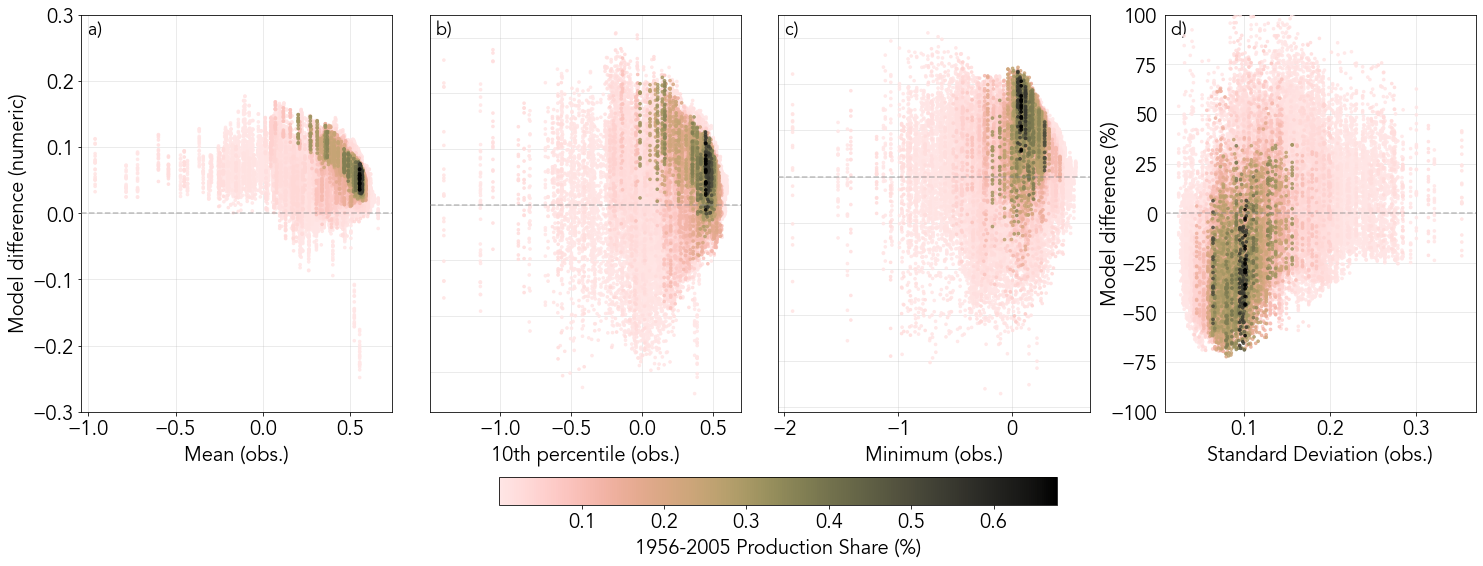

In [66]:
gridspec = dict(wspace = 0.15, hspace=0.005, width_ratios=[1, 1, 1, 0., 1])
fig, axs = plt.subplots(1,5, figsize=(25,10), gridspec_kw=gridspec)
axs = axs.flatten()

axs[3].set_visible(False)

##############################
# Second row
##############################

# Choose how many counties
n = len(weights_all['national_weight'])
top_n = weights_all['national_weight'].sort_values()[-n:].index
weights_plot = weights_all.loc[top_n]['national_weight'].values * 100 # as percentage
colors = np.reshape([[v]*21 for v in get_custom_cmap(weights_plot)], (21*n,4))

# Mean
ax=axs[0]
ax.scatter(np.transpose([gmfd_weather_mean.loc[top_n].values] * 21),
           nex_weather_mean.loc[top_n].values - np.transpose([gmfd_weather_mean.loc[top_n].values] * 21),
           c = colors,
           s = 7,
           alpha=0.8, zorder=10)

ax.set_xlim([np.min(ax.get_xlim()),np.max(ax.get_xlim())])
ax.hlines(0, xmin=np.min(ax.get_xlim()), xmax=np.max(ax.get_xlim()), ls='--', color='grey', alpha=0.5, zorder=20)
ax.set_ylim([-0.3,0.3])
ax.grid(alpha=0.3, zorder=0)
ax.set_ylabel('Model difference (numeric)')
ax.set_xlabel('Mean (obs.)')
ax.text(0.005, 0.95, ' a)', transform=ax.transAxes, size=18)

# 10th percentile
ax=axs[1]
ax.scatter(np.transpose([gmfd_weather_q10.loc[top_n].values] * 21),
           nex_weather_q10.loc[top_n].values - np.transpose([gmfd_weather_q10.loc[top_n].values] * 21),
           c = colors,
           s = 7,
           alpha=0.8,
           zorder=10)

ax.set_xlim(ax.get_xlim())
ax.hlines(0, xmin=np.min(ax.get_xlim()), xmax=np.max(ax.get_xlim()), ls='--', color='grey', alpha=0.5, zorder=20)
ax.grid(alpha=0.3, zorder=0)
ax.set_xlabel('10th percentile (obs.)')
ax.tick_params(axis='y', which='both', left=False, labelleft=False)
ax.text(0.005, 0.95, ' b)', transform=ax.transAxes, size=18)

# Min
ax=axs[2]
ax.scatter(np.transpose([gmfd_weather_min.loc[top_n].values] * 21),
           nex_weather_min.loc[top_n].values - np.transpose([gmfd_weather_min.loc[top_n].values] * 21),
           c = colors,
           s = 7,
           alpha=0.8,
           zorder=10)

ax.set_xlim(ax.get_xlim())
ax.hlines(0, xmin=np.min(ax.get_xlim()), xmax=np.max(ax.get_xlim()), ls='--', color='grey', alpha=0.5, zorder=20)
ax.grid(alpha=0.3, zorder=0)
ax.set_xlabel('Minimum (obs.)')
ax.tick_params(axis='y', which='both', left=False, labelleft=False)
ax.text(0.005, 0.95, ' c)', transform=ax.transAxes, size=18)

# SD
ax=axs[4]
ax.scatter(np.transpose([gmfd_weather_sd.loc[top_n].values] * 21),
           100 * (nex_weather_sd.loc[top_n].values - np.transpose([gmfd_weather_sd.loc[top_n].values] * 21)) / np.abs(np.transpose([gmfd_weather_sd.loc[top_n].values] * 21)),
           c = colors,
           s = 7,
           alpha=0.8, zorder=10)

ax.set_xlim([np.min(ax.get_xlim()),np.max(ax.get_xlim())])
ax.hlines(0, xmin=np.min(ax.get_xlim()), xmax=np.max(ax.get_xlim()), ls='--', color='grey', alpha=0.5, zorder=20)
ax.grid(alpha=0.3, zorder=0)
ax.set_xlabel('Standard Deviation (obs.)')
ax.tick_params(axis='y', which='both', left=False)
ax.set_ylim([-100,100])
ax.set_ylabel('Model difference (%)', labelpad=-10)
ax.text(0.005, 0.95, ' d)', transform=ax.transAxes, size=18)

# Plot
cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=get_norm(weights_plot), cmap=turku_map), orientation='horizontal', ax = axs[:], shrink=0.4, pad=0.12)
cbar.ax.set_xlabel('1956-2005 Production Share (%)')

# plt.show()
plt.savefig('../../figs/new/SIfig_NEX_yield_scatter.png', dpi=600)

### NEX: EDD

In [67]:
# EDD metrics
nex_edd_q90 = nex_edd.groupby('fips').quantile(q=0.9)
gmfd_edd_q90 = gmfd.groupby('fips').quantile(q=0.9)['edd']

nex_edd_max = nex_edd.groupby('fips').max()
gmfd_edd_max = gmfd.groupby('fips').max()['edd']

nex_edd_mean = nex_edd.groupby('fips').mean()
gmfd_edd_mean = gmfd.groupby('fips').mean()['edd']

nex_edd_sd = nex_edd.groupby('fips').std()
gmfd_edd_sd = gmfd.groupby('fips').std()['edd']

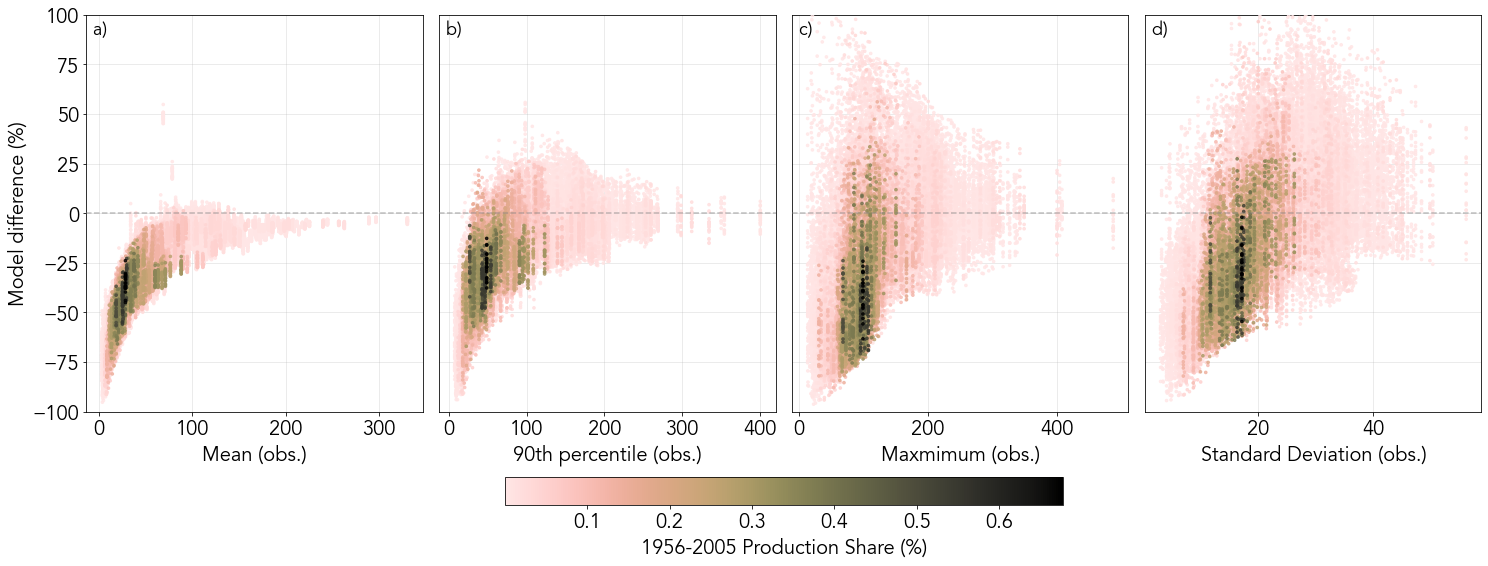

In [68]:
fig, axs = plt.subplots(1,4, figsize=(25,10), gridspec_kw={'wspace':0.05}, sharey=True)
axs = axs.flatten()

##############################
# Second row
##############################

# Choose how many counties
n = len(weights_all['national_weight'])
top_n = weights_all['national_weight'].sort_values()[-n:].index
weights_plot = weights_all.loc[top_n]['national_weight'].values * 100 # as percentage
colors = np.reshape([[v]*21 for v in get_custom_cmap(weights_plot)], (21*n,4))

# Mean
ax=axs[0]
ax.scatter(np.transpose([gmfd_edd_mean.loc[top_n].values] * 21),
           100 * (nex_edd_mean.loc[top_n].values - np.transpose([gmfd_edd_mean.loc[top_n].values] * 21)) / np.abs(np.transpose([gmfd_edd_mean.loc[top_n].values] * 21)),
           c = colors,
           s = 7,
           alpha=0.8, zorder=10)

ax.set_xlim([np.min(ax.get_xlim()),np.max(ax.get_xlim())])
ax.hlines(0, xmin=np.min(ax.get_xlim()), xmax=np.max(ax.get_xlim()), ls='--', color='grey', alpha=0.5, zorder=20)
ax.set_ylim([-100,100])
ax.set_ylabel('Model difference (%)')
ax.grid(alpha=0.3, zorder=0)
ax.set_xlabel('Mean (obs.)')
ax.text(0.005, 0.95, ' a)', transform=ax.transAxes, size=18)

# 10th percentile
ax=axs[1]
ax.scatter(np.transpose([gmfd_edd_q90.loc[top_n].values] * 21),
           100 * (nex_edd_q90.loc[top_n].values - np.transpose([gmfd_edd_q90.loc[top_n].values] * 21)) / np.abs(np.transpose([gmfd_edd_q90.loc[top_n].values] * 21)),
           c = colors,
           s = 7,
           alpha=0.8,
           zorder=10)

ax.set_xlim(ax.get_xlim())
ax.hlines(0, xmin=np.min(ax.get_xlim()), xmax=np.max(ax.get_xlim()), ls='--', color='grey', alpha=0.5, zorder=20)
ax.grid(alpha=0.3, zorder=0)
ax.set_xlabel('90th percentile (obs.)')
ax.tick_params(axis='y', which='both', left=False, labelleft=False)
ax.text(0.005, 0.95, ' b)', transform=ax.transAxes, size=18)

# Min
ax=axs[2]
ax.scatter(np.transpose([gmfd_edd_max.loc[top_n].values] * 21),
           100 * (nex_edd_max.loc[top_n].values - np.transpose([gmfd_edd_max.loc[top_n].values] * 21)) / np.abs(np.transpose([gmfd_edd_max.loc[top_n].values] * 21)),
           c = colors,
           s = 7,
           alpha=0.8,
           zorder=10)

ax.set_xlim(ax.get_xlim())
ax.hlines(0, xmin=np.min(ax.get_xlim()), xmax=np.max(ax.get_xlim()), ls='--', color='grey', alpha=0.5, zorder=20)
ax.grid(alpha=0.3, zorder=0)
ax.set_xlabel('Maxmimum (obs.)')
ax.tick_params(axis='y', which='both', left=False, labelleft=False)
ax.text(0.005, 0.95, ' c)', transform=ax.transAxes, size=18)

# SD
ax=axs[3]
ax.scatter(np.transpose([gmfd_edd_sd.loc[top_n].values] * 21),
           100 * (nex_edd_sd.loc[top_n].values - np.transpose([gmfd_edd_sd.loc[top_n].values] * 21)) / np.abs(np.transpose([gmfd_edd_sd.loc[top_n].values] * 21)),
           c = colors,
           s = 7,
           alpha=0.8, zorder=10)

ax.set_xlim([np.min(ax.get_xlim()),np.max(ax.get_xlim())])
ax.hlines(0, xmin=np.min(ax.get_xlim()), xmax=np.max(ax.get_xlim()), ls='--', color='grey', alpha=0.5, zorder=20)
ax.grid(alpha=0.3, zorder=0)
ax.set_xlabel('Standard Deviation (obs.)')
ax.tick_params(axis='y', which='both', left=False)
ax.text(0.005, 0.95, ' d)', transform=ax.transAxes, size=18)

# Plot
cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=get_norm(weights_plot), cmap=turku_map), orientation='horizontal', ax = axs[:], shrink=0.4, pad=0.12)
cbar.ax.set_xlabel('1956-2005 Production Share (%)')

# plt.show()
plt.savefig('../../figs/new/SIfig_NEX_EDD_scatter.png', dpi=600)

### NEX: GDD

In [69]:
# GDD metrics
nex_gdd_q10 = nex_gdd.groupby('fips').quantile(q=0.1)
gmfd_gdd_q10 = gmfd.groupby('fips').quantile(q=0.1)['gdd']

nex_gdd_min = nex_gdd.groupby('fips').min()
gmfd_gdd_min = gmfd.groupby('fips').min()['gdd']

nex_gdd_mean = nex_gdd.groupby('fips').mean()
gmfd_gdd_mean = gmfd.groupby('fips').mean()['gdd']

nex_gdd_sd = nex_gdd.groupby('fips').std()
gmfd_gdd_sd = gmfd.groupby('fips').std()['gdd']

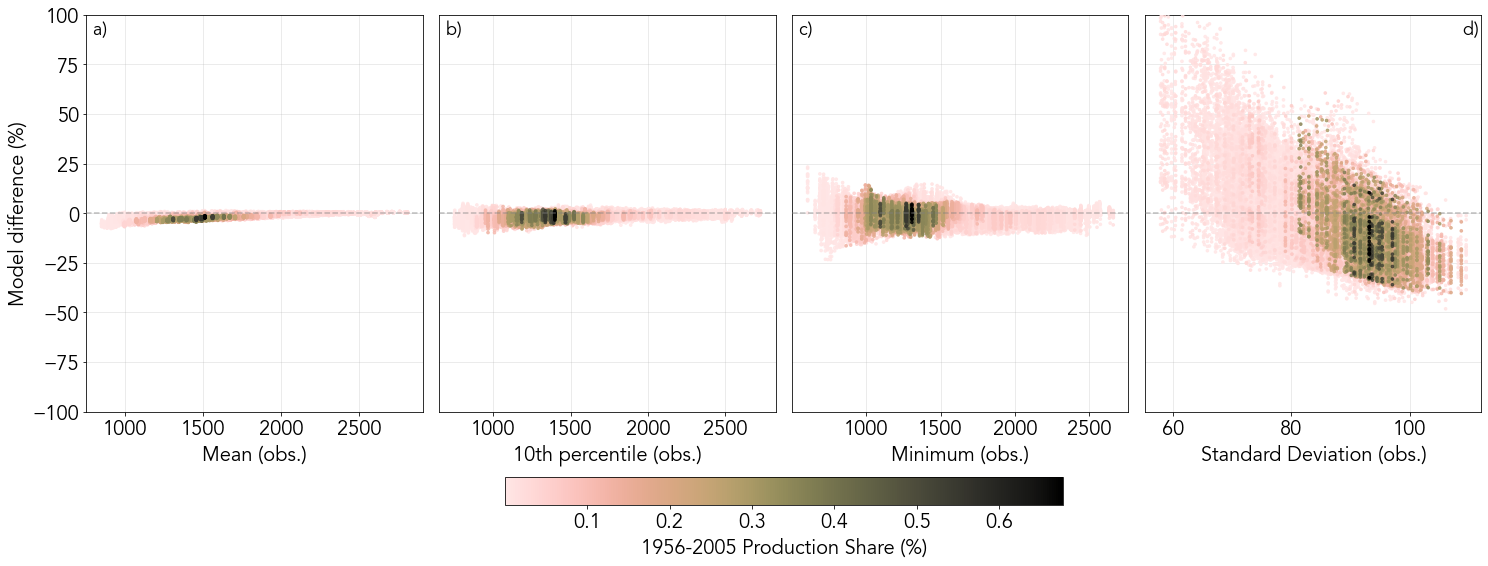

In [70]:
fig, axs = plt.subplots(1,4, figsize=(25,10), gridspec_kw={'wspace':0.05}, sharey=True)
axs = axs.flatten()

##############################
# Second row
##############################

# Choose how many counties
n = len(weights_all['national_weight'])
top_n = weights_all['national_weight'].sort_values()[-n:].index
weights_plot = weights_all.loc[top_n]['national_weight'].values * 100 # as percentage
colors = np.reshape([[v]*21 for v in get_custom_cmap(weights_plot)], (21*n,4))

# Mean
ax=axs[0]
ax.scatter(np.transpose([gmfd_gdd_mean.loc[top_n].values] * 21),
           100 * (nex_gdd_mean.loc[top_n].values - np.transpose([gmfd_gdd_mean.loc[top_n].values] * 21)) / np.abs(np.transpose([gmfd_gdd_mean.loc[top_n].values] * 21)),
           c = colors,
           s = 7,
           alpha=0.8, zorder=10)

ax.set_xlim([np.min(ax.get_xlim()),np.max(ax.get_xlim())])
ax.hlines(0, xmin=np.min(ax.get_xlim()), xmax=np.max(ax.get_xlim()), ls='--', color='grey', alpha=0.5, zorder=20)
ax.set_ylim([-100,100])
ax.set_ylabel('Model difference (%)')
ax.grid(alpha=0.3, zorder=0)
ax.set_xlabel('Mean (obs.)')
ax.text(0.005, 0.95, ' a)', transform=ax.transAxes, size=18)

# 10th percentile
ax=axs[1]
ax.scatter(np.transpose([gmfd_gdd_q10.loc[top_n].values] * 21),
           100 * (nex_gdd_q10.loc[top_n].values - np.transpose([gmfd_gdd_q10.loc[top_n].values] * 21)) / np.abs(np.transpose([gmfd_gdd_q10.loc[top_n].values] * 21)),
           c = colors,
           s = 7,
           alpha=0.8,
           zorder=10)

ax.set_xlim(ax.get_xlim())
ax.hlines(0, xmin=np.min(ax.get_xlim()), xmax=np.max(ax.get_xlim()), ls='--', color='grey', alpha=0.5, zorder=20)
ax.grid(alpha=0.3, zorder=0)
ax.set_xlabel('10th percentile (obs.)')
ax.tick_params(axis='y', which='both', left=False, labelleft=False)
ax.text(0.005, 0.95, ' b)', transform=ax.transAxes, size=18)

# Min
ax=axs[2]
ax.scatter(np.transpose([gmfd_gdd_min.loc[top_n].values] * 21),
           100 * (nex_gdd_min.loc[top_n].values - np.transpose([gmfd_gdd_min.loc[top_n].values] * 21)) / np.abs(np.transpose([gmfd_gdd_min.loc[top_n].values] * 21)),
           c = colors,
           s = 7,
           alpha=0.8,
           zorder=10)

ax.set_xlim(ax.get_xlim())
ax.hlines(0, xmin=np.min(ax.get_xlim()), xmax=np.max(ax.get_xlim()), ls='--', color='grey', alpha=0.5, zorder=20)
ax.grid(alpha=0.3, zorder=0)
ax.set_xlabel('Minimum (obs.)')
ax.tick_params(axis='y', which='both', left=False, labelleft=False)
ax.text(0.005, 0.95, ' c)', transform=ax.transAxes, size=18)

# SD
ax=axs[3]
ax.scatter(np.transpose([gmfd_gdd_sd.loc[top_n].values] * 21),
           100 * (nex_gdd_sd.loc[top_n].values - np.transpose([gmfd_gdd_sd.loc[top_n].values] * 21)) / np.abs(np.transpose([gmfd_gdd_sd.loc[top_n].values] * 21)),
           c = colors,
           s = 7,
           alpha=0.8, zorder=10)

ax.set_xlim([np.min(ax.get_xlim()),np.max(ax.get_xlim())])
ax.hlines(0, xmin=np.min(ax.get_xlim()), xmax=np.max(ax.get_xlim()), ls='--', color='grey', alpha=0.5, zorder=20)
ax.grid(alpha=0.3, zorder=0)
ax.set_xlabel('Standard Deviation (obs.)')
ax.tick_params(axis='y', which='both', left=False)
ax.text(0.93, 0.95, ' d)', transform=ax.transAxes, size=18)

# Plot
cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=get_norm(weights_plot), cmap=turku_map), orientation='horizontal', ax = axs[:], shrink=0.4, pad=0.12)
cbar.ax.set_xlabel('1956-2005 Production Share (%)')

# plt.show()
plt.savefig('../../figs/new/SIfig_NEX_GDD_scatter.png', dpi=600)

### NEX: Precip

In [71]:
# Precip metrics
nex_prcp_q10 = nex_prcp.groupby('fips').quantile(q=0.1)
gmfd_prcp_q10 = gmfd.groupby('fips').quantile(q=0.1)['prcp']

nex_prcp_mean = nex_prcp.groupby('fips').mean()
gmfd_prcp_mean = gmfd.groupby('fips').mean()['prcp']

nex_prcp_min = nex_prcp.groupby('fips').min()
gmfd_prcp_min = gmfd.groupby('fips').min()['prcp']

nex_prcp_sd = nex_prcp.groupby('fips').std()
gmfd_prcp_sd = gmfd.groupby('fips').std()['prcp']

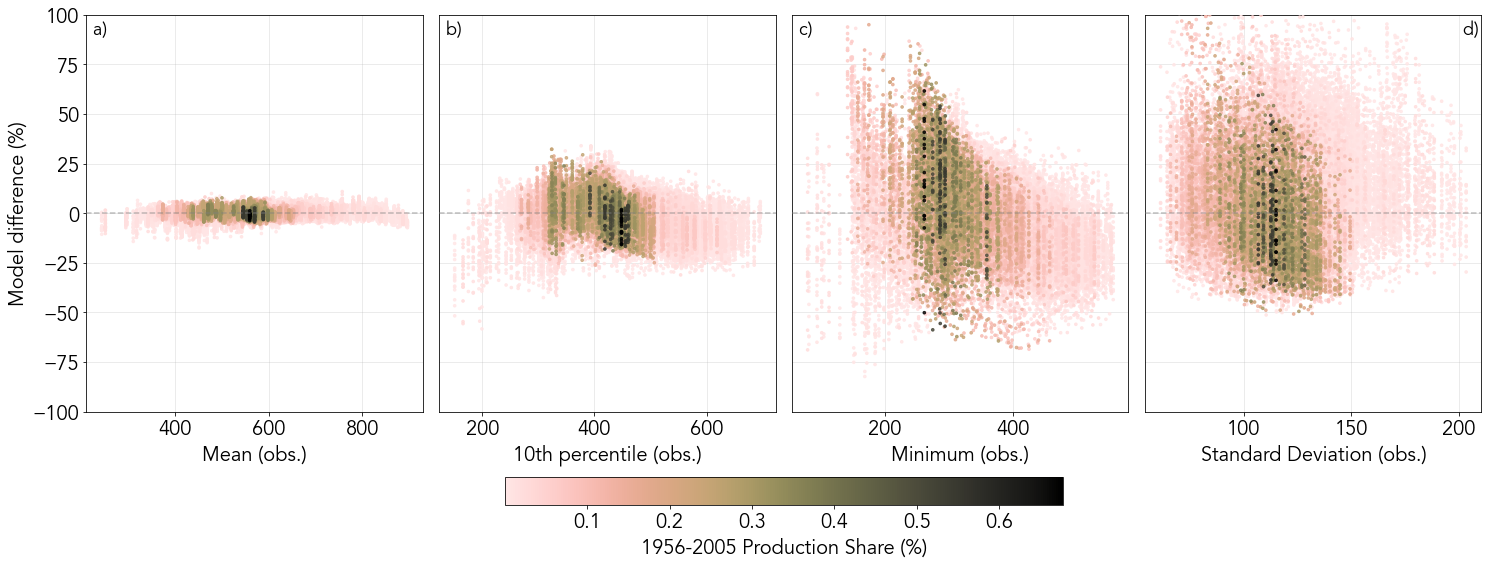

In [72]:
fig, axs = plt.subplots(1,4, figsize=(25,10), gridspec_kw={'wspace':0.05}, sharey=True)
axs = axs.flatten()

##############################
# Second row
##############################

# Choose how many counties
n = len(weights_all['national_weight'])
top_n = weights_all['national_weight'].sort_values()[-n:].index
weights_plot = weights_all.loc[top_n]['national_weight'].values * 100 # as percentage
colors = np.reshape([[v]*21 for v in get_custom_cmap(weights_plot)], (21*n,4))

# Mean
ax=axs[0]
ax.scatter(np.transpose([gmfd_prcp_mean.loc[top_n].values] * 21),
           100 * (nex_prcp_mean.loc[top_n].values - np.transpose([gmfd_prcp_mean.loc[top_n].values] * 21)) / np.abs(np.transpose([gmfd_prcp_mean.loc[top_n].values] * 21)),
           c = colors,
           s = 7,
           alpha=0.8, zorder=10)

ax.set_xlim([np.min(ax.get_xlim()),np.max(ax.get_xlim())])
ax.hlines(0, xmin=np.min(ax.get_xlim()), xmax=np.max(ax.get_xlim()), ls='--', color='grey', alpha=0.5, zorder=20)
ax.set_ylim([-100,100])
ax.set_ylabel('Model difference (%)')
ax.grid(alpha=0.3, zorder=0)
ax.set_xlabel('Mean (obs.)')
ax.text(0.005, 0.95, ' a)', transform=ax.transAxes, size=18)

# 10th percentile
ax=axs[1]
ax.scatter(np.transpose([gmfd_prcp_q10.loc[top_n].values] * 21),
           100 * (nex_prcp_q10.loc[top_n].values - np.transpose([gmfd_prcp_q10.loc[top_n].values] * 21)) / np.abs(np.transpose([gmfd_prcp_q10.loc[top_n].values] * 21)),
           c = colors,
           s = 7,
           alpha=0.8,
           zorder=10)

ax.set_xlim(ax.get_xlim())
ax.hlines(0, xmin=np.min(ax.get_xlim()), xmax=np.max(ax.get_xlim()), ls='--', color='grey', alpha=0.5, zorder=20)
ax.grid(alpha=0.3, zorder=0)
ax.set_xlabel('10th percentile (obs.)')
ax.tick_params(axis='y', which='both', left=False, labelleft=False)
ax.text(0.005, 0.95, ' b)', transform=ax.transAxes, size=18)

# Min
ax=axs[2]
ax.scatter(np.transpose([gmfd_prcp_min.loc[top_n].values] * 21),
           100 * (nex_prcp_min.loc[top_n].values - np.transpose([gmfd_prcp_min.loc[top_n].values] * 21)) / np.abs(np.transpose([gmfd_prcp_min.loc[top_n].values] * 21)),
           c = colors,
           s = 7,
           alpha=0.8,
           zorder=10)

ax.set_xlim(ax.get_xlim())
ax.hlines(0, xmin=np.min(ax.get_xlim()), xmax=np.max(ax.get_xlim()), ls='--', color='grey', alpha=0.5, zorder=20)
ax.grid(alpha=0.3, zorder=0)
ax.set_xlabel('Minimum (obs.)')
ax.tick_params(axis='y', which='both', left=False, labelleft=False)
ax.text(0.005, 0.95, ' c)', transform=ax.transAxes, size=18)

# SD
ax=axs[3]
ax.scatter(np.transpose([gmfd_prcp_sd.loc[top_n].values] * 21),
           100 * (nex_prcp_sd.loc[top_n].values - np.transpose([gmfd_prcp_sd.loc[top_n].values] * 21)) / np.abs(np.transpose([gmfd_prcp_sd.loc[top_n].values] * 21)),
           c = colors,
           s = 7,
           alpha=0.8, zorder=10)

ax.set_xlim([np.min(ax.get_xlim()),np.max(ax.get_xlim())])
ax.hlines(0, xmin=np.min(ax.get_xlim()), xmax=np.max(ax.get_xlim()), ls='--', color='grey', alpha=0.5, zorder=20)
ax.grid(alpha=0.3, zorder=0)
ax.set_xlabel('Standard Deviation (obs.)')
ax.tick_params(axis='y', which='both', left=False)
ax.text(0.93, 0.95, ' d)', transform=ax.transAxes, size=18)

# Plot
cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=get_norm(weights_plot), cmap=turku_map), orientation='horizontal', ax = axs[:], shrink=0.4, pad=0.12)
cbar.ax.set_xlabel('1956-2005 Production Share (%)')

# plt.show()
plt.savefig('../../figs/new/SIfig_NEX_Precip_scatter.png', dpi=600)

### CMIP: Yield

In [73]:
# Read in CMIP models
cmip_models = !ls ../../data/climate/CMIP
cmip = {model.replace("agvar_","").replace("historical+rcp85","").replace(".csv","").replace(".csv","")[:-1] : pd.read_csv("../../data/climate/CMIP/" + model) for model in cmip_models}
cmip_models = [model.replace("agvar_","").replace("historical+rcp85","").replace(".csv","")[:-1] for model in cmip_models]

# CMIP EDD
cmip_edd = pd.DataFrame.from_dict({model : cmip[model].set_index(['fips','year'])['edd'] for model in cmip_models}).dropna()
cmip_edd = cmip_edd.reset_index()
cmip_edd["fips"] = cmip_edd["fips"].astype(str).str.zfill(5)
cmip_edd.set_index(['fips','year'], inplace=True)

# CMIP GDD
cmip_gdd = pd.DataFrame.from_dict({model : cmip[model].set_index(['fips','year'])['gdd'] for model in cmip_models}).dropna()
cmip_gdd = cmip_gdd.reset_index()
cmip_gdd["fips"] = cmip_gdd["fips"].astype(str).str.zfill(5)
cmip_gdd.set_index(['fips','year'], inplace=True)

# CMIP GDD
cmip_prcp = pd.DataFrame.from_dict({model : cmip[model].set_index(['fips','year'])['prcp'] for model in cmip_models}).dropna()
cmip_prcp = cmip_prcp.reset_index()
cmip_prcp["fips"] = cmip_prcp["fips"].astype(str).str.zfill(5)
cmip_prcp.set_index(['fips','year'], inplace=True)

# CMIP weather
for model in cmip_models:
    tmp = cmip[model]
    tmp['prcp2'] = tmp['prcp']**2
    tmp['weather'] = tmp.apply(get_weather, axis=1)
    cmip[model] = tmp

cmip_weather = pd.DataFrame.from_dict({model : cmip[model].set_index(['fips','year'])['weather'] for model in cmip_models}).dropna()
cmip_weather = cmip_weather.reset_index()
cmip_weather["fips"] = cmip_weather["fips"].astype(str).str.zfill(5)
cmip_weather.set_index(['fips','year'], inplace=True)   

In [74]:
# Yield metrics (model by model)
cmip_weather_q10 = cmip_weather.groupby('fips').quantile(q=0.1)
gmfd_weather_q10 = gmfd.groupby('fips').quantile(q=0.1)['weather']

cmip_weather_mean = cmip_weather.groupby('fips').mean()
gmfd_weather_mean = gmfd.groupby('fips').mean()['weather']

cmip_weather_sd = cmip_weather.groupby('fips').std()
gmfd_weather_sd = gmfd.groupby('fips').std()['weather']

cmip_weather_min = cmip_weather.groupby('fips').min()
gmfd_weather_min = gmfd.groupby('fips').min()['weather']

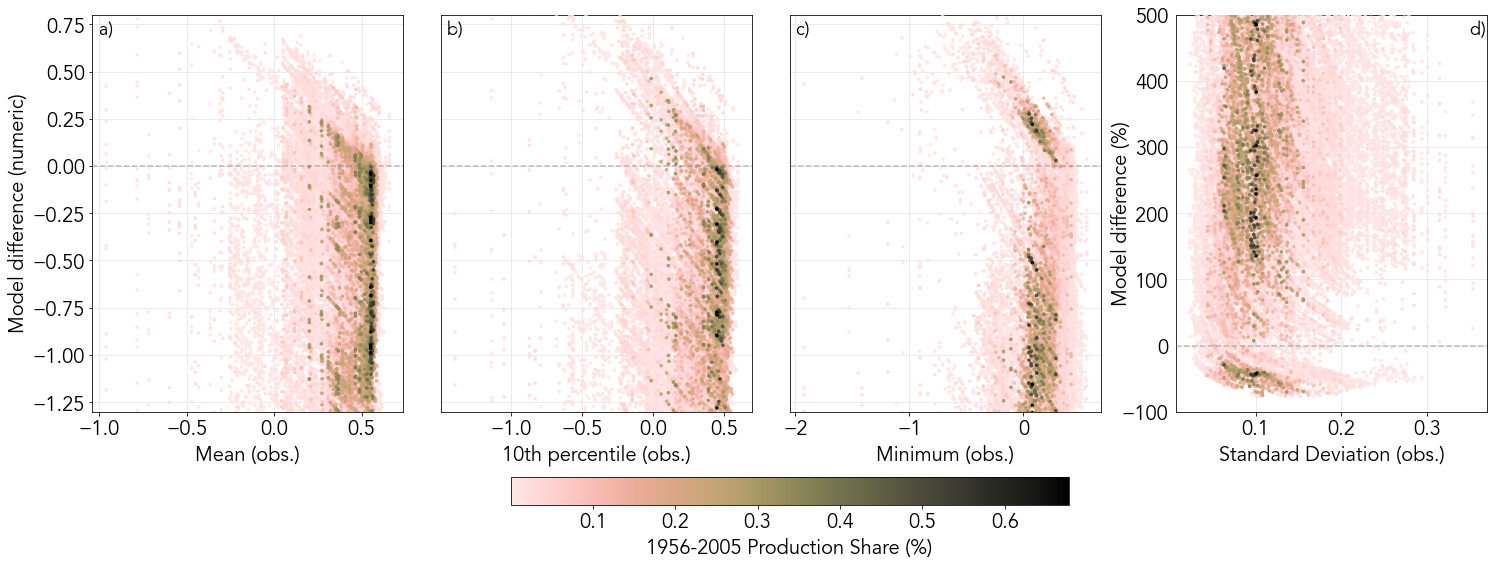

In [75]:
gridspec = dict(wspace = 0.15, hspace=0.005, width_ratios=[1, 1, 1, 0., 1])
fig, axs = plt.subplots(1,5, figsize=(25,10), gridspec_kw=gridspec)
axs = axs.flatten()

axs[3].set_visible(False)

##############################
# Second row
##############################

# Choose how many counties
n = len(weights_all['national_weight'])
top_n = weights_all['national_weight'].sort_values()[-n:].index
weights_plot = weights_all.loc[top_n]['national_weight'].values * 100 # as percentage
colors = np.reshape([[v]*21 for v in get_custom_cmap(weights_plot)], (21*n,4))

# Mean
ax=axs[0]
ax.scatter(np.transpose([gmfd_weather_mean.loc[top_n].values] * 21),
           cmip_weather_mean.loc[top_n].values - np.transpose([gmfd_weather_mean.loc[top_n].values] * 21),
           c = colors,
           s = 7,
           alpha=0.8, zorder=10)

ax.set_xlim([np.min(ax.get_xlim()),np.max(ax.get_xlim())])
ax.hlines(0, xmin=np.min(ax.get_xlim()), xmax=np.max(ax.get_xlim()), ls='--', color='grey', alpha=0.5, zorder=20)
ax.set_ylim([-1.3,0.8])
ax.grid(alpha=0.3, zorder=0)
ax.set_ylabel('Model difference (numeric)')
ax.set_xlabel('Mean (obs.)')
ax.text(0.005, 0.95, ' a)', transform=ax.transAxes, size=18)

# 10th percentile
ax=axs[1]
ax.scatter(np.transpose([gmfd_weather_q10.loc[top_n].values] * 21),
           cmip_weather_q10.loc[top_n].values - np.transpose([gmfd_weather_q10.loc[top_n].values] * 21),
           c = colors,
           s = 7,
           alpha=0.8,
           zorder=10)

ax.set_xlim(ax.get_xlim())
ax.set_ylim([-1.3,0.8])
ax.hlines(0, xmin=np.min(ax.get_xlim()), xmax=np.max(ax.get_xlim()), ls='--', color='grey', alpha=0.5, zorder=20)
ax.grid(alpha=0.3, zorder=0)
ax.set_xlabel('10th percentile (obs.)')
ax.tick_params(axis='y', which='both', left=False, labelleft=False)
ax.text(0.005, 0.95, ' b)', transform=ax.transAxes, size=18)

# Min
ax=axs[2]
ax.scatter(np.transpose([gmfd_weather_min.loc[top_n].values] * 21),
           cmip_weather_min.loc[top_n].values - np.transpose([gmfd_weather_min.loc[top_n].values] * 21),
           c = colors,
           s = 7,
           alpha=0.8,
           zorder=10)

ax.set_xlim(ax.get_xlim())
ax.set_ylim([-1.3,0.8])
ax.hlines(0, xmin=np.min(ax.get_xlim()), xmax=np.max(ax.get_xlim()), ls='--', color='grey', alpha=0.5, zorder=20)
ax.grid(alpha=0.3, zorder=0)
ax.set_xlabel('Minimum (obs.)')
ax.tick_params(axis='y', which='both', left=False, labelleft=False)
ax.text(0.005, 0.95, ' c)', transform=ax.transAxes, size=18)

# SD
ax=axs[4]
ax.scatter(np.transpose([gmfd_weather_sd.loc[top_n].values] * 21),
           100 * (cmip_weather_sd.loc[top_n].values - np.transpose([gmfd_weather_sd.loc[top_n].values] * 21)) / np.abs(np.transpose([gmfd_weather_sd.loc[top_n].values] * 21)),
           c = colors,
           s = 7,
           alpha=0.8, zorder=10)

ax.set_xlim([np.min(ax.get_xlim()),np.max(ax.get_xlim())])
ax.hlines(0, xmin=np.min(ax.get_xlim()), xmax=np.max(ax.get_xlim()), ls='--', color='grey', alpha=0.5, zorder=20)
ax.grid(alpha=0.3, zorder=0)
ax.set_xlabel('Standard Deviation (obs.)')
ax.tick_params(axis='y', which='both', left=False)
ax.set_ylim([-100,500])
ax.set_ylabel('Model difference (%)', labelpad=-10)
ax.text(0.93, 0.95, ' d)', transform=ax.transAxes, size=18)

# Plot
cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=get_norm(weights_plot), cmap=turku_map), orientation='horizontal', ax = axs[:], shrink=0.4, pad=0.12)
cbar.ax.set_xlabel('1956-2005 Production Share (%)')

# plt.show()
plt.savefig('../../figs/new/SIfig_CMIP_yield_scatter.png', dpi=600)

### CMIP: EDD

In [76]:
# EDD metrics
cmip_edd_q90 = cmip_edd.groupby('fips').quantile(q=0.9)
gmfd_edd_q90 = gmfd.groupby('fips').quantile(q=0.9)['edd']

cmip_edd_mean = cmip_edd.groupby('fips').mean()
gmfd_edd_mean = gmfd.groupby('fips').mean()['edd']

cmip_edd_max = cmip_edd.groupby('fips').max()
gmfd_edd_max = gmfd.groupby('fips').max()['edd']

cmip_edd_sd = cmip_edd.groupby('fips').std()
gmfd_edd_sd = gmfd.groupby('fips').std()['edd']

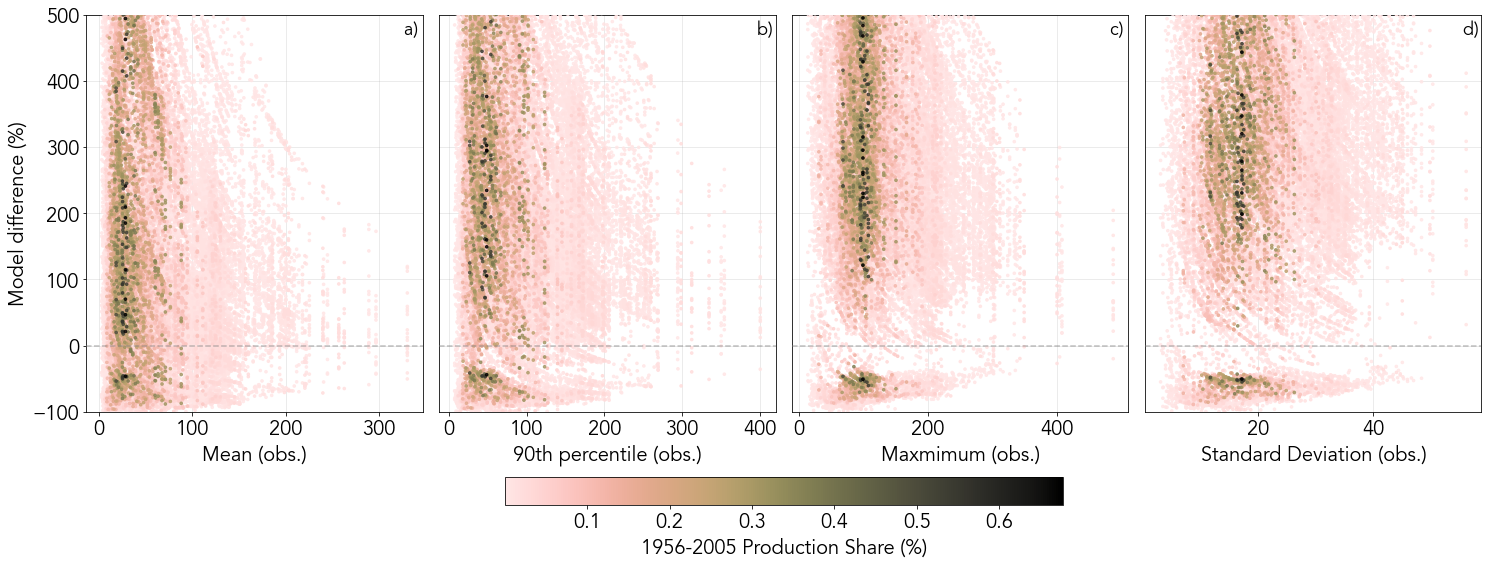

In [77]:
fig, axs = plt.subplots(1,4, figsize=(25,10), gridspec_kw={'wspace':0.05}, sharey=True)
axs = axs.flatten()

##############################
# Second row
##############################

# Choose how many counties
n = len(weights_all['national_weight'])
top_n = weights_all['national_weight'].sort_values()[-n:].index
weights_plot = weights_all.loc[top_n]['national_weight'].values * 100 # as percentage
colors = np.reshape([[v]*21 for v in get_custom_cmap(weights_plot)], (21*n,4))

# Mean
ax=axs[0]
ax.scatter(np.transpose([gmfd_edd_mean.loc[top_n].values] * 21),
           100 * (cmip_edd_mean.loc[top_n].values - np.transpose([gmfd_edd_mean.loc[top_n].values] * 21)) / np.abs(np.transpose([gmfd_edd_mean.loc[top_n].values] * 21)),
           c = colors,
           s = 7,
           alpha=0.8, zorder=10)

ax.set_xlim([np.min(ax.get_xlim()),np.max(ax.get_xlim())])
ax.hlines(0, xmin=np.min(ax.get_xlim()), xmax=np.max(ax.get_xlim()), ls='--', color='grey', alpha=0.5, zorder=20)
ax.set_ylim([-100,500])
ax.set_ylabel('Model difference (%)')
ax.grid(alpha=0.3, zorder=0)
ax.set_xlabel('Mean (obs.)')
ax.text(0.93, 0.95, ' a)', transform=ax.transAxes, size=18)

# 10th percentile
ax=axs[1]
ax.scatter(np.transpose([gmfd_edd_q90.loc[top_n].values] * 21),
           100 * (cmip_edd_q90.loc[top_n].values - np.transpose([gmfd_edd_q90.loc[top_n].values] * 21)) / np.abs(np.transpose([gmfd_edd_q90.loc[top_n].values] * 21)),
           c = colors,
           s = 7,
           alpha=0.8,
           zorder=10)

ax.set_xlim(ax.get_xlim())
ax.hlines(0, xmin=np.min(ax.get_xlim()), xmax=np.max(ax.get_xlim()), ls='--', color='grey', alpha=0.5, zorder=20)
ax.grid(alpha=0.3, zorder=0)
ax.set_xlabel('90th percentile (obs.)')
ax.tick_params(axis='y', which='both', left=False, labelleft=False)
ax.text(0.93, 0.95, ' b)', transform=ax.transAxes, size=18)

# Max
ax=axs[2]
ax.scatter(np.transpose([gmfd_edd_max.loc[top_n].values] * 21),
           100 * (cmip_edd_max.loc[top_n].values - np.transpose([gmfd_edd_max.loc[top_n].values] * 21)) / np.abs(np.transpose([gmfd_edd_max.loc[top_n].values] * 21)),
           c = colors,
           s = 7,
           alpha=0.8,
           zorder=10)

ax.set_xlim(ax.get_xlim())
ax.hlines(0, xmin=np.min(ax.get_xlim()), xmax=np.max(ax.get_xlim()), ls='--', color='grey', alpha=0.5, zorder=20)
ax.grid(alpha=0.3, zorder=0)
ax.set_xlabel('Maxmimum (obs.)')
ax.tick_params(axis='y', which='both', left=False, labelleft=False)
ax.text(0.93, 0.95, ' c)', transform=ax.transAxes, size=18)

# SD
ax=axs[3]
ax.scatter(np.transpose([gmfd_edd_sd.loc[top_n].values] * 21),
           100 * (cmip_edd_sd.loc[top_n].values - np.transpose([gmfd_edd_sd.loc[top_n].values] * 21)) / np.abs(np.transpose([gmfd_edd_sd.loc[top_n].values] * 21)),
           c = colors,
           s = 7,
           alpha=0.8, zorder=10)

ax.set_xlim([np.min(ax.get_xlim()),np.max(ax.get_xlim())])
ax.hlines(0, xmin=np.min(ax.get_xlim()), xmax=np.max(ax.get_xlim()), ls='--', color='grey', alpha=0.5, zorder=20)
ax.grid(alpha=0.3, zorder=0)
ax.set_xlabel('Standard Deviation (obs.)')
ax.tick_params(axis='y', which='both', left=False)
ax.text(0.93, 0.95, ' d)', transform=ax.transAxes, size=18)

# Plot
cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=get_norm(weights_plot), cmap=turku_map), orientation='horizontal', ax = axs[:], shrink=0.4, pad=0.12)
cbar.ax.set_xlabel('1956-2005 Production Share (%)')

# plt.show()
plt.savefig('../../figs/new/SIfig_CMIP_EDD_scatter.png', dpi=600)

### CMIP: GDD

In [78]:
# GDD metrics
cmip_gdd_q10 = cmip_gdd.groupby('fips').quantile(q=0.1)
gmfd_gdd_q10 = gmfd.groupby('fips').quantile(q=0.1)['gdd']

cmip_gdd_min = cmip_gdd.groupby('fips').min()
gmfd_gdd_min = gmfd.groupby('fips').min()['gdd']

cmip_gdd_mean = cmip_gdd.groupby('fips').mean()
gmfd_gdd_mean = gmfd.groupby('fips').mean()['gdd']

cmip_gdd_sd = cmip_gdd.groupby('fips').std()
gmfd_gdd_sd = gmfd.groupby('fips').std()['gdd']

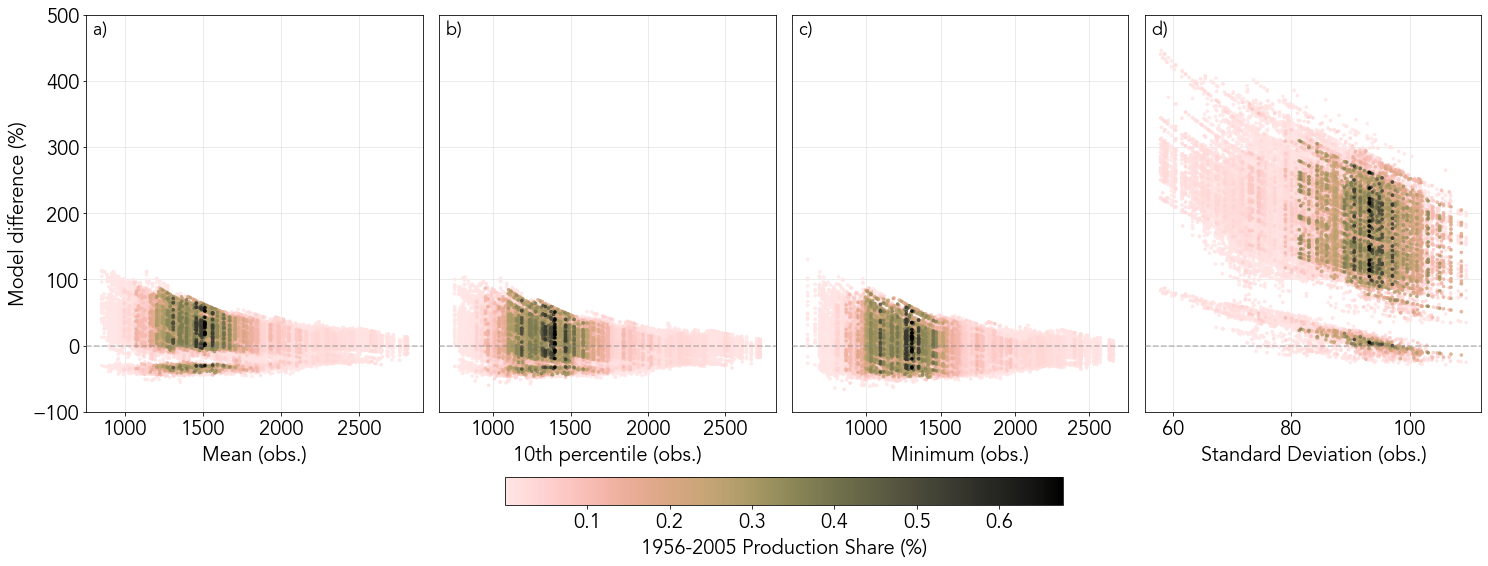

In [79]:
fig, axs = plt.subplots(1,4, figsize=(25,10), gridspec_kw={'wspace':0.05}, sharey=True)
axs = axs.flatten()

##############################
# Second row
##############################

# Choose how many counties
n = len(weights_all['national_weight'])
top_n = weights_all['national_weight'].sort_values()[-n:].index
weights_plot = weights_all.loc[top_n]['national_weight'].values * 100 # as percentage
colors = np.reshape([[v]*21 for v in get_custom_cmap(weights_plot)], (21*n,4))

# Mean
ax=axs[0]
ax.scatter(np.transpose([gmfd_gdd_mean.loc[top_n].values] * 21),
           100 * (cmip_gdd_mean.loc[top_n].values - np.transpose([gmfd_gdd_mean.loc[top_n].values] * 21)) / np.abs(np.transpose([gmfd_gdd_mean.loc[top_n].values] * 21)),
           c = colors,
           s = 7,
           alpha=0.8, zorder=10)

ax.set_xlim([np.min(ax.get_xlim()),np.max(ax.get_xlim())])
ax.hlines(0, xmin=np.min(ax.get_xlim()), xmax=np.max(ax.get_xlim()), ls='--', color='grey', alpha=0.5, zorder=20)
ax.set_ylim([-100,500])
ax.set_ylabel('Model difference (%)')
ax.grid(alpha=0.3, zorder=0)
ax.set_xlabel('Mean (obs.)')
ax.text(0.005, 0.95, ' a)', transform=ax.transAxes, size=18)

# 10th percentile
ax=axs[1]
ax.scatter(np.transpose([gmfd_gdd_q10.loc[top_n].values] * 21),
           100 * (cmip_gdd_q10.loc[top_n].values - np.transpose([gmfd_gdd_q10.loc[top_n].values] * 21)) / np.abs(np.transpose([gmfd_gdd_q10.loc[top_n].values] * 21)),
           c = colors,
           s = 7,
           alpha=0.8,
           zorder=10)

ax.set_xlim(ax.get_xlim())
ax.hlines(0, xmin=np.min(ax.get_xlim()), xmax=np.max(ax.get_xlim()), ls='--', color='grey', alpha=0.5, zorder=20)
ax.grid(alpha=0.3, zorder=0)
ax.set_xlabel('10th percentile (obs.)')
ax.tick_params(axis='y', which='both', left=False, labelleft=False)
ax.text(0.005, 0.95, ' b)', transform=ax.transAxes, size=18)

# Min
ax=axs[2]
ax.scatter(np.transpose([gmfd_gdd_min.loc[top_n].values] * 21),
           100 * (cmip_gdd_min.loc[top_n].values - np.transpose([gmfd_gdd_min.loc[top_n].values] * 21)) / np.abs(np.transpose([gmfd_gdd_min.loc[top_n].values] * 21)),
           c = colors,
           s = 7,
           alpha=0.8,
           zorder=10)

ax.set_xlim(ax.get_xlim())
ax.hlines(0, xmin=np.min(ax.get_xlim()), xmax=np.max(ax.get_xlim()), ls='--', color='grey', alpha=0.5, zorder=20)
ax.grid(alpha=0.3, zorder=0)
ax.set_xlabel('Minimum (obs.)')
ax.tick_params(axis='y', which='both', left=False, labelleft=False)
ax.text(0.005, 0.95, ' c)', transform=ax.transAxes, size=18)

# SD
ax=axs[3]
ax.scatter(np.transpose([gmfd_gdd_sd.loc[top_n].values] * 21),
           100 * (cmip_gdd_sd.loc[top_n].values - np.transpose([gmfd_gdd_sd.loc[top_n].values] * 21)) / np.abs(np.transpose([gmfd_gdd_sd.loc[top_n].values] * 21)),
           c = colors,
           s = 7,
           alpha=0.8, zorder=10)

ax.set_xlim([np.min(ax.get_xlim()),np.max(ax.get_xlim())])
ax.hlines(0, xmin=np.min(ax.get_xlim()), xmax=np.max(ax.get_xlim()), ls='--', color='grey', alpha=0.5, zorder=20)
ax.grid(alpha=0.3, zorder=0)
ax.set_xlabel('Standard Deviation (obs.)')
ax.tick_params(axis='y', which='both', left=False)
ax.text(0.005, 0.95, ' d)', transform=ax.transAxes, size=18)

# Plot
cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=get_norm(weights_plot), cmap=turku_map), orientation='horizontal', ax = axs[:], shrink=0.4, pad=0.12)
cbar.ax.set_xlabel('1956-2005 Production Share (%)')

# plt.show()
plt.savefig('../../figs/new/SIfig_CMIP_GDD_scatter.png', dpi=600)

### CMIP: Precip

In [80]:
# Precip metrics
cmip_prcp_q10 = cmip_prcp.groupby('fips').quantile(q=0.1)
gmfd_prcp_q10 = gmfd.groupby('fips').quantile(q=0.1)['prcp']

cmip_prcp_mean = cmip_prcp.groupby('fips').mean()
gmfd_prcp_mean = gmfd.groupby('fips').mean()['prcp']

cmip_prcp_min = cmip_prcp.groupby('fips').min()
gmfd_prcp_min = gmfd.groupby('fips').min()['prcp']

cmip_prcp_sd = cmip_prcp.groupby('fips').std()
gmfd_prcp_sd = gmfd.groupby('fips').std()['prcp']

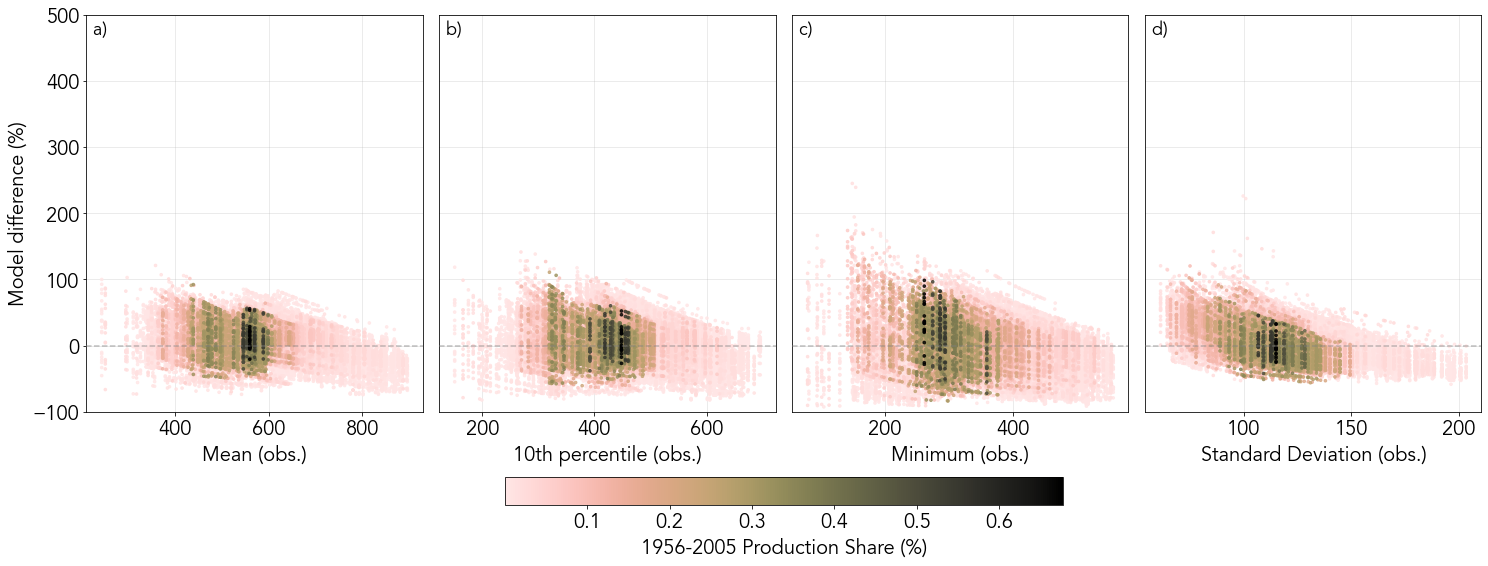

In [81]:
fig, axs = plt.subplots(1,4, figsize=(25,10), gridspec_kw={'wspace':0.05}, sharey=True)
axs = axs.flatten()

##############################
# Second row
##############################

# Choose how many counties
n = len(weights_all['national_weight'])
top_n = weights_all['national_weight'].sort_values()[-n:].index
weights_plot = weights_all.loc[top_n]['national_weight'].values * 100 # as percentage
colors = np.reshape([[v]*21 for v in get_custom_cmap(weights_plot)], (21*n,4))

# Mean
ax=axs[0]
ax.scatter(np.transpose([gmfd_prcp_mean.loc[top_n].values] * 21),
           100 * (cmip_prcp_mean.loc[top_n].values - np.transpose([gmfd_prcp_mean.loc[top_n].values] * 21)) / np.abs(np.transpose([gmfd_prcp_mean.loc[top_n].values] * 21)),
           c = colors,
           s = 7,
           alpha=0.8, zorder=10)

ax.set_xlim([np.min(ax.get_xlim()),np.max(ax.get_xlim())])
ax.hlines(0, xmin=np.min(ax.get_xlim()), xmax=np.max(ax.get_xlim()), ls='--', color='grey', alpha=0.5, zorder=20)
ax.set_ylim([-100,500])
ax.set_ylabel('Model difference (%)')
ax.grid(alpha=0.3, zorder=0)
ax.set_xlabel('Mean (obs.)')
ax.text(0.005, 0.95, ' a)', transform=ax.transAxes, size=18)

# 10th percentile
ax=axs[1]
ax.scatter(np.transpose([gmfd_prcp_q10.loc[top_n].values] * 21),
           100 * (cmip_prcp_q10.loc[top_n].values - np.transpose([gmfd_prcp_q10.loc[top_n].values] * 21)) / np.abs(np.transpose([gmfd_prcp_q10.loc[top_n].values] * 21)),
           c = colors,
           s = 7,
           alpha=0.8,
           zorder=10)

ax.set_xlim(ax.get_xlim())
ax.hlines(0, xmin=np.min(ax.get_xlim()), xmax=np.max(ax.get_xlim()), ls='--', color='grey', alpha=0.5, zorder=20)
ax.grid(alpha=0.3, zorder=0)
ax.set_xlabel('10th percentile (obs.)')
ax.tick_params(axis='y', which='both', left=False, labelleft=False)
ax.text(0.005, 0.95, ' b)', transform=ax.transAxes, size=18)

# Min
ax=axs[2]
ax.scatter(np.transpose([gmfd_prcp_min.loc[top_n].values] * 21),
           100 * (cmip_prcp_min.loc[top_n].values - np.transpose([gmfd_prcp_min.loc[top_n].values] * 21)) / np.abs(np.transpose([gmfd_prcp_min.loc[top_n].values] * 21)),
           c = colors,
           s = 7,
           alpha=0.8,
           zorder=10)

ax.set_xlim(ax.get_xlim())
ax.hlines(0, xmin=np.min(ax.get_xlim()), xmax=np.max(ax.get_xlim()), ls='--', color='grey', alpha=0.5, zorder=20)
ax.grid(alpha=0.3, zorder=0)
ax.set_xlabel('Minimum (obs.)')
ax.tick_params(axis='y', which='both', left=False, labelleft=False)
ax.text(0.005, 0.95, ' c)', transform=ax.transAxes, size=18)

# SD
ax=axs[3]
ax.scatter(np.transpose([gmfd_prcp_sd.loc[top_n].values] * 21),
           100 * (cmip_prcp_sd.loc[top_n].values - np.transpose([gmfd_prcp_sd.loc[top_n].values] * 21)) / np.abs(np.transpose([gmfd_prcp_sd.loc[top_n].values] * 21)),
           c = colors,
           s = 7,
           alpha=0.8, zorder=10)

ax.set_xlim([np.min(ax.get_xlim()),np.max(ax.get_xlim())])
ax.hlines(0, xmin=np.min(ax.get_xlim()), xmax=np.max(ax.get_xlim()), ls='--', color='grey', alpha=0.5, zorder=20)
ax.grid(alpha=0.3, zorder=0)
ax.set_xlabel('Standard Deviation (obs.)')
ax.tick_params(axis='y', which='both', left=False)
ax.text(0.005, 0.95, ' d)', transform=ax.transAxes, size=18)

# Plot
cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=get_norm(weights_plot), cmap=turku_map), orientation='horizontal', ax = axs[:], shrink=0.4, pad=0.12)
cbar.ax.set_xlabel('1956-2005 Production Share (%)')

# plt.show()
plt.savefig('../../figs/new/SIfig_CMIP_Precip_scatter.png', dpi=600)